In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest

from sklearn.metrics import mean_squared_error
import math


In [3]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'France-Saint Pierre and Miquelon', 'Micronesia', 'France-French Polynesia', 'France-Martinique', 'Slovakia', 'Canada-Repatriated Travellers', 'United Kingdom-British Virgin Islands', 'China-Henan', 'Kyrgyzstan', 'Congo (Brazzaville)', 'China-Hunan', 'United Kingdom-Montserrat', 'United Kingdom-Anguilla', 'United Kingdom-Jersey', 'Gambia', 'Canada-Prince Edward Island', 'France-Reunion', 'Australia-Northern Territory', 'Saint Lucia', 'China-Shanghai', 'Canada-Diamond Princess', 'Canada-Ontario', 'Antarctica', 'Saint Vincent and the Grenadines', 'China-Ningxia', 'Australia-New South Wales', 'Netherlands-Aruba', 'China-Shaanxi', 'China-Unknown', 'France-French Guiana', 'West Bank and Gaza', 'China-Xinjiang', 'China-Qinghai', 'China-Guizhou', 'Canada-Manitoba', 'China-Guangdong', 'Canada-Newfoundland and Labrador', 'France-Mayotte', 'MS Zaandam', 'United Kingdom-Gu

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns &

In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [6]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

# Testing our donorpool selection method

In [7]:
all_cases_data_pop_daily.columns

Index(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia',
       ...
       'York-South Carolina', 'York-Virginia', 'Young-Texas',
       'Yuba-California', 'Yukon-Koyukuk Census Area-Alaska', 'Yuma-Arizona',
       'Yuma-Colorado', 'Zapata-Texas', 'Zavala-Texas',
       'Ziebach-South Dakota'],
      dtype='object', length=3371)

In [40]:
import collections
import plotly.figure_factory as ff
from urllib.request import urlopen
import datetime as dt

donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)


targets = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if (names[-1] == 'New York' or names[-1] == 'Connecticut' or names[-1] == 'Massachusetts') and names[0] != 'Unknown':
        targets.append(counties)


In [9]:
print(targets)

['Addison-Vermont', 'Bennington-Vermont', 'Caledonia-Vermont', 'Chittenden-Vermont', 'Essex-Vermont', 'Franklin-Vermont', 'Grand Isle-Vermont', 'Lamoille-Vermont', 'Orange-Vermont', 'Orleans-Vermont', 'Rutland-Vermont', 'Washington-Vermont', 'Windham-Vermont', 'Windsor-Vermont']


In [10]:
print(len(donors))

146


## Compute MSE for our donor selection model; Backward Donor Elimination

In [11]:
def backward_donor_elimination(rscModel,metric=mean_squared_error, output = 'error_ratio', shuffle = False):
    '''
    Find the error ratio from removing each of the states within the donorpool

    @param
    metric: metric used to calculate ri values
    '''
    def syn_fit(shuffled_df,donorPool, hi_thresh,low_thresh):
        temp_model = syn_model(rscModel.state, rscModel.kSingularValues, [shuffled_df], hi_thresh, low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        return temp_model
    
    def find_lo_high_thresh(donorPool, error_ratio = True):
        hi_thresh = rscModel.low_thresh if error_ratio else rscModel.thresh
        low_thresh = int(rscModel.low_thresh*.8) if error_ratio else rscModel.low_thresh
        shuffled_df = rscModel.dfs[0].iloc[:hi_thresh,:]
        if shuffle:
            shuffled_df = shuffled_df.iloc[np.random.permutation(len(shuffled_df))] 
        temp_model = syn_fit(shuffled_df,donorPool, hi_thresh,low_thresh)
        return temp_model.find_ri(metric) if error_ratio else temp_model.train_err

    out_dict = dict()
        
    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        #only pre-intervention
        
        if output == 'error_ratio': 
            '''
            hi_thresh, low_thresh = rscModel.low_thresh, int(rscModel.low_thresh*.8)
            temp_model = syn_fit()
            out_dict[donor] = temp_model.find_ri(metric)
            '''
            out_dict[donor] = find_lo_high_thresh(donorPool, error_ratio = True)
            
        elif output == 'training_error':
            '''
            hi_thresh, low_thresh = rscModel.thresh, rscModel.low_thresh
            temp_model = syn_fit()
            out_dict[donor] = temp_model.train_err
            '''
            out_dict[donor] = find_lo_high_thresh(donorPool, error_ratio = False)
            
        #models[donor] = temp_model
        
        '''
        all_donors = np.array(list(out_dict.keys()))
        values = np.array(list(out_dict.values()))
        max_value = max(values)
        new_donors = all_donors[(values < max_value)]
        new_values = values[(values < max_value)]

        new_donors, new_values = all_donors, values
        '''
    
    new_donors = np.array(list(out_dict.keys()))
    values = np.array(list(out_dict.values()))
    max_value = max(values)
    print('donors:', len(new_donors),'removed:',new_donors[values == max_value ])
    new_donors,values = new_donors[(values < max_value)], values[(values < max_value)]
    
    return new_donors


In [15]:
outliers = ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']

### eliminiate donors until the training error no longer decreases (break condition)

In [41]:
#df = df[df.columns[(df>100).any()]].copy()
import warnings
warnings.filterwarnings("ignore")

start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
#high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = int(low_thresh/0.8)
high_thresh, low_thresh = low_thresh, int(low_thresh*.8)



plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:# for state in ['Albany-New York']: #
    
    #otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    # Adding outliers:
    for item in outliers:
        otherStates.append(item)
        
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
      
    rscModel1 = rscModel
    final_donors = rscModel1.donors
    print('\n\ntarget:', state)
    while len(final_donors)>3:
        #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        #train_err1 = rscModel.train_err
        new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')
        
        '''
        print(new_donors)
        rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
        rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        '''
        rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(new_donors))
        #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
        #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

        print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
        if rscModel1.train_err <= rscModel2.train_err:
            break
        final_donors = new_donors
        rscModel1 = rscModel2
    #print(final_donors)    

        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel1.testing_error())
    train_MSE[1].append(rscModel1.training_error())
    donor_size[1].append(rscModel1.donors)
    singvals[1].append(rscModel1.kSingularValues)
    target_counties.append(state)
    
    



target: Albany-New York
donors: 42 removed: ['Schenectady-New York']
training error before: 92.7643682112655 training error after: 123.11696651309664


target: Allegany-New York
donors: 39 removed: ['Ontario-New York']
training error before: 62.55596979134211 training error after: 65.21736408566925


target: Barnstable-Massachusetts
donors: 42 removed: ['Franklin-Massachusetts']
training error before: 198.95552224924722 training error after: 220.6528264730549


target: Berkshire-Massachusetts
donors: 43 removed: ['Franklin-Massachusetts']


KeyboardInterrupt: 

In [155]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[13.566563883581441, 263.28374011684974, 230.73492748177364, 4585.4930860865925, 1.1076415789087704, 507.90912703535076, 143.91066647273507, 26.20158844808983, 885.5708201619096, 1255.8269538721863, 109.17188426778796, 2621.447900264533, 2531.9113981703385, 220.70964714087532, 1278.696230005233, 70.94194708439119, 244.1088689293223, 2366.5665139213406, 36.15832146698239, 37.46693142317683, 63.04714592828166, 46.286207699712236, 7.386486190223825, 70.6135685930531, 42.753627972600825, 80.64471376345814, 82.09839472326922, 5167.787107947476, 37.279783187555125, 18.683609219637905, 690.245821852601, 10631.787376225951, 8.384715109450088, 230.50770883709953, 4747.480858396573, 89.13603302191618, 3905.739950071289, 2424.669874064338, 792.0010776467107, 46.45007084398518, 639.1188693295347, 83.13178076993191, 1697.8702760457388, 48.89977862406683, 41.21388492721196, 6062.428142545908, 6616.649256593516, 112.07080080159892, 6.339431388295554, 75.18046265757349, 1935.331699992658, 

### eliminiate donors until the error ratio no longer decreases (break condition)

In [18]:
#df = df[df.columns[(df>100).any()]].copy()
import warnings
warnings.filterwarnings("ignore")

start_date = '2021-10-01'
low_thresh_date = '2021-12-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []
target_donors = {}
target_detected_outliers ={}
i=1


hi_thresh, lo_thresh = low_thresh, int(low_thresh*.8)
for state in donors:# for state in ['Albany-New York']: #
#otherStates = donors.copy()
    try:
        # TODO: should I replaced low_thresh with 0?
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    # Adding outliers:
    for item in outliers:
        otherStates.append(item)
    '''
    
    rscModel =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue

      
    #hi_thresh, lo_thresh = rscModel.low_thresh, int(rscModel.low_thresh*.8)
    rscModel1 = rscModel
    final_donors = rscModel1.donors
    print('\n\ntarget:', state)
    while len(final_donors)>3:
        
        new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, shuffle = False)
        
        '''
        print(new_donors)
        rscModel1 =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=final_donors)
        rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        '''
        rscModel2 =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=list(new_donors))
        #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, hi_thresh, low_thresh, 
        #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

        print('error ratio before:', rscModel1.find_ri(mean_squared_error),'error ratio after:',  rscModel2.find_ri(mean_squared_error))
        if rscModel1.find_ri(mean_squared_error) <= rscModel2.find_ri(mean_squared_error):
            break
        final_donors = new_donors
        rscModel1 = rscModel2
    #print(final_donors)    
            
    target_donors[state] = final_donors
    
    target_detected_outliers[state]=list(set(otherStates)-set(final_donors))    
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel1.testing_error())
    train_MSE[1].append(rscModel1.training_error())
    donor_size[1].append(rscModel1.donors)
    singvals[1].append(rscModel1.kSingularValues)
    target_counties.append(state)
    
    



target: Addison-Vermont
donors: 14 removed: ['Lamoille-Vermont']
error ratio before: 43.485043779585276 error ratio after: 12.36506910034731
donors: 13 removed: ['Grand Isle-Vermont']
error ratio before: 12.36506910034731 error ratio after: 11.134971347330811
donors: 12 removed: ['Waldo-Maine']
error ratio before: 11.134971347330811 error ratio after: 32.51403793836984


target: Albany-New York
donors: 139 removed: ['Coos-New Hampshire']
error ratio before: 1.1981953781451167 error ratio after: 1.359970565775004


target: Allegany-New York
donors: 137 removed: ['Rutland-Vermont']
error ratio before: 0.4290632179215945 error ratio after: 0.4004756426446723
donors: 136 removed: ['Washington-New York']
error ratio before: 0.4004756426446723 error ratio after: 0.34302815937300657
donors: 135 removed: ['Bennington-Vermont']
error ratio before: 0.34302815937300657 error ratio after: 0.30513006922776625
donors: 134 removed: ['Caledonia-Vermont']
error ratio before: 0.30513006922776625 error

error ratio before: 7.955960593550876 error ratio after: 7.872370735605084
donors: 77 removed: ['Knox-Maine']
error ratio before: 7.872370735605084 error ratio after: 7.8545377399631064
donors: 76 removed: ['Franklin-New York']
error ratio before: 7.8545377399631064 error ratio after: 7.639108593367466
donors: 75 removed: ['Somerset-Maine']
error ratio before: 7.639108593367466 error ratio after: 8.62073856438953


target: Essex-Vermont
donors: 138 removed: ['Caledonia-Vermont']
error ratio before: 1.8320686375181918 error ratio after: 1.826037540223305
donors: 137 removed: ['Washington-New York']
error ratio before: 1.826037540223305 error ratio after: 1.6952769498037012
donors: 136 removed: ['Rutland-Vermont']
error ratio before: 1.6952769498037012 error ratio after: 1.6777114899314944
donors: 135 removed: ['Bennington-Vermont']
error ratio before: 1.6777114899314944 error ratio after: 1.6034981532092272
donors: 134 removed: ['Franklin-Vermont']
error ratio before: 1.6034981532092272

donors: 139 removed: ['Belknap-New Hampshire']
error ratio before: 17.833895251833503 error ratio after: 18.40596587426647


target: Merrimack-New Hampshire
donors: 136 removed: ['Rutland-Vermont']
error ratio before: 0.4788687398111095 error ratio after: 0.5013714429335353


target: Middlesex-Connecticut
donors: 119 removed: ['Piscataquis-Maine']
error ratio before: 43.02962984003833 error ratio after: 46.66404031112819


target: Middlesex-Massachusetts
donors: 134 removed: ['Rutland-Vermont']
error ratio before: 20.55817688135881 error ratio after: 20.69439115393318


target: Middlesex-New Jersey
donors: 136 removed: ['Coos-New Hampshire']
error ratio before: 2.6090248803510274 error ratio after: 2.3070372003774424
donors: 135 removed: ['Orleans-Vermont']
error ratio before: 2.3070372003774424 error ratio after: 16.510955676274293


target: Monmouth-New Jersey
donors: 128 removed: ['Coos-New Hampshire']
error ratio before: 7.73048738755141 error ratio after: 14.433619232637602


targ

error ratio before: 6.105272113725605 error ratio after: 6.2033129205763755


target: Rockingham-New Hampshire
donors: 141 removed: ['Washington-New York']
error ratio before: 1.5245309411699022 error ratio after: 1.5978955358730365


target: Rockland-New York
donors: 120 removed: ['Coos-New Hampshire']
error ratio before: 1.6623985675779092 error ratio after: 1.7610072974575177


target: Rutland-Vermont
donors: 118 removed: ['Orleans-Vermont']
error ratio before: 1.5674098018790978 error ratio after: 1.5978856531933445


target: Sagadahoc-Maine
donors: 41 removed: ['Piscataquis-Maine']
error ratio before: 4.111823116270848 error ratio after: 4.637373792460476


target: Salem-New Jersey
donors: 134 removed: ['Coos-New Hampshire']
error ratio before: 0.328633685022081 error ratio after: 0.37128773335463056


target: Saratoga-New York
donors: 136 removed: ['Sullivan-New Hampshire']
error ratio before: 24.84047700069345 error ratio after: 25.822820005475993


target: Schenectady-New York




target: Wyoming-New York
donors: 136 removed: ['Essex-Vermont']
error ratio before: 9.601100614467542 error ratio after: 9.121721386034746
donors: 135 removed: ['Washington-New York']
error ratio before: 9.121721386034746 error ratio after: 9.444176035746256


target: Yates-New York
donors: 76 removed: ['Hamilton-New York']
error ratio before: 3.0549104347425886 error ratio after: 2.744256713627095
donors: 75 removed: ['Piscataquis-Maine']
error ratio before: 2.744256713627095 error ratio after: 0.256050497509258
donors: 74 removed: ['St. Lawrence-New York']
error ratio before: 0.256050497509258 error ratio after: 0.22846418160229173
donors: 73 removed: ['Waldo-Maine']
error ratio before: 0.22846418160229173 error ratio after: 0.14505812401630597
donors: 72 removed: ['Washington-Vermont']
error ratio before: 0.14505812401630597 error ratio after: 0.15832419089830477


target: York-Maine
donors: 118 removed: ['Orleans-Vermont']
error ratio before: 1.4613566398802587 error ratio after:

In [19]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[18939.060156272008, 1123.8865426370207, 8414.668593719416, 24778.477421519132, 145585.68363719046, 8148.380835132809, 25834.620151054547, 12112.53995869407, 30998.107577595296, 1167.8750864937579, 30365.739689122132, 17150.45255886527, 21610.29114460588, 6031.852049538722, 2806.7420280978354, 22101.20108357571, 1369.8336784257363, 8925.85904371527, 4489.76429709709, 31960.149257190307, 1008.1540018659217, 55606.12718621797, 27025.199570504075, 13381.597431729677, 4730.012426359667, 5091.612022229518, 3758.210996399702, 38214.80455180078, 319843.411394785, 19946.779236917697, 2524.3370284007397, 2782.476907056521, 3365.8966081305243, 2045.1496841153134, 249.80992433453108, 51922.28233347368, 18244.39171197162, 2863.5601571376965, 25675.858179775416, 88810.79955008572, 3385.7293250064718, 65575.48296059624, 33098.69811891968, 7422.266028694639, 16036.084655961033, 13604.924252522485, 15007.184385593137, 3202.2422315894855, 2298.4898976505315, 56241.872626434946, 5578.3790131

In [20]:
TP = 0
FN = 0
FP = 0

for state in target_donors:
    for item in target_detected_outliers[state]: 
        if item in outliers:
            TP+=1
        else: 
            FP+=1

            
recall = TP/(len(outliers)*len(target_donors))
precision = TP/(TP+FP)
print(precision, recall)


0.0 0.0


In [67]:
'''
precision, recall = 0.028362305580969808 0.03538812785388128
error ratio standard: 13.274418462512111
error ratio, our method: 11.821525721639594
'''

'\nprecision, recall = 0.028362305580969808 0.03538812785388128\nerror ratio standard: 13.274418462512111\nerror ratio, our method: 11.821525721639594\n'

## histogram based outlier detection


In [35]:
def permutation_train_test(rscModel, train_err = True, include_self = False):
    out_dict = dict()
    #models = dict()

    if include_self:
        if train_err:
            out_dict[rscModel.state] = rscModel.train_err
        else: 
            out_dict[rscModel.state] = rscModel.test_err 

    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        temp_model = syn_model(donor, rscModel.kSingularValues, rscModel.dfs, rscModel.thresh, rscModel.low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        if train_err:
            out_dict[donor] = temp_model.train_err
        else: 
            out_dict[donor] = temp_model.test_err 
        #models[donor] = temp_model


    return out_dict


def get_pre_filter(state, singVals, high_thresh, low_thresh):
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                  > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        return
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
    # Adding outliers:
    for item in outliers:
        otherStates.append(item)
        
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        return
    
    return rscModel#.testing_error(), rscModel.training_error(), rscModel.donors, rscModel.kSingularValues
    

--------------- 
 Albany-New York
15.55935030241113 20.1095667504778 0.2630493841708856 110.17253161884547


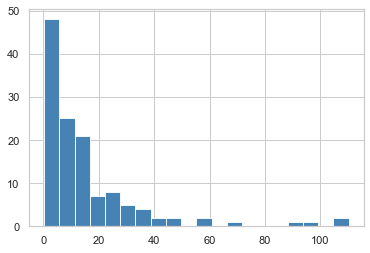

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Allegany-New York
9.953653229213646 13.539747292608686 0.19426010903826837 76.65487445118504


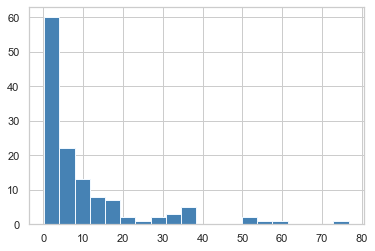

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'York-Maine' 'Cleburne-Alabama']
--------------- 
 Barnstable-Massachusetts
10.290968783649099 13.367248077890881 0.19327888143962743 77.90905198541857


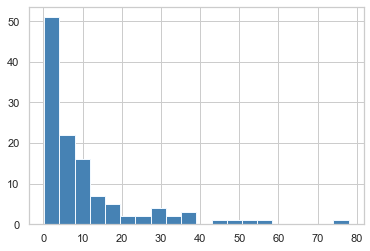

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'York-Maine' 'Cleburne-Alabama']
--------------- 
 Berkshire-Massachusetts
23.420186521931974 33.18532583008981 0.1355342169943005 161.85990804852537


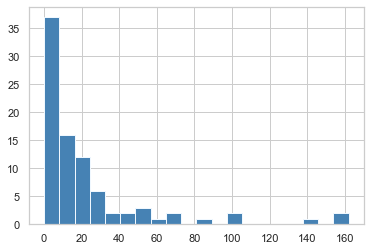

['Cattaraugus-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Lincoln-Maine' 'Orleans-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Vermont'
 'Cleburne-Alabama']
--------------- 
 Bristol-Massachusetts
11.771511118046337 13.215996856193765 0.24108370772884022 66.53832134692716


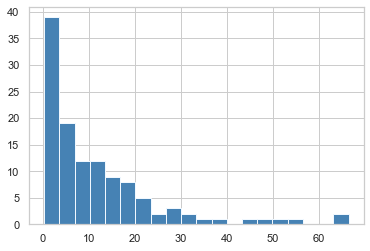

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Wyoming-New York']
--------------- 
 Broome-New York
11.508179919401615 13.903352095852615 0.2894890566051149 72.35821223788702


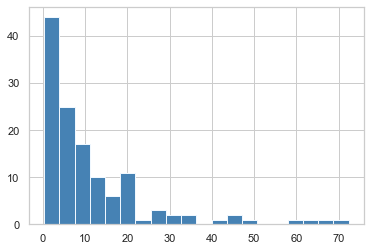

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York']
--------------- 
 Cattaraugus-New York
16.41954367353109 21.476673644341577 0.22773497287691538 111.6785333794259


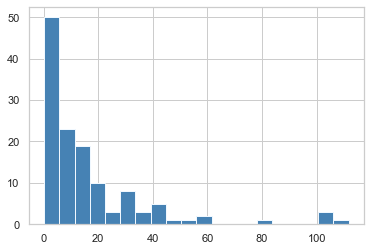

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Lincoln-Maine' 'Madison-New York'
 'Montgomery-New York' 'Oneida-New York' 'Orleans-New York'
 'Penobscot-Maine' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Cayuga-New York
15.17102590326302 19.455619182116628 0.38395101842443924 116.10373045598519


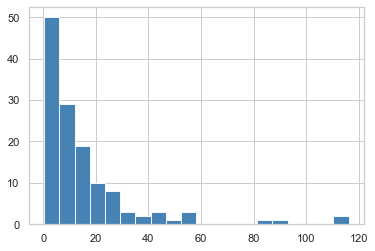

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Chautauqua-New York
9.936886429372635 13.410850448486377 0.1846853081771115 75.90983496542702


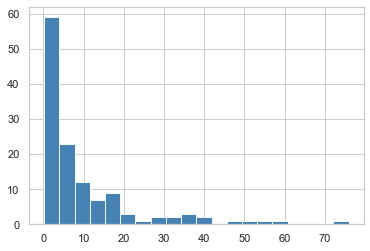

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'York-Maine' 'Cleburne-Alabama']
--------------- 
 Chemung-New York
11.515540817620407 14.016433826918822 0.30002823029042713 73.19547295122655


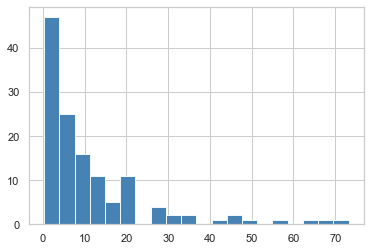

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York']
--------------- 
 Chenango-New York
15.832136552821304 20.18946043155671 0.2287638878797188 109.82827928800428


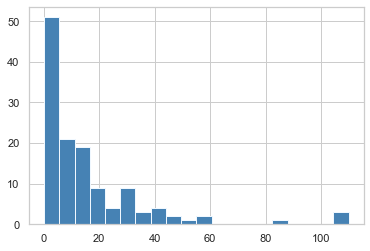

['Allegany-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Lincoln-Maine' 'Madison-New York' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Penobscot-Maine'
 'Rensselaer-New York' 'Sagadahoc-Maine' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Clinton-New York
13.55078280975466 20.180652236465498 0.09157671744354375 131.3517300915891


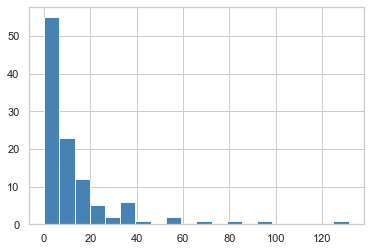

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Hampshire-Massachusetts' 'Madison-New York'
 'Montgomery-New York' 'Onondaga-New York' 'Oswego-New York'
 'Sullivan-New Hampshire' 'Wayne-New York' 'Wyoming-New York' 'York-Maine'
 'Cleburne-Alabama']
--------------- 
 Columbia-New York
13.46609981485591 17.91704525505948 0.16009407248896196 115.02355943008857


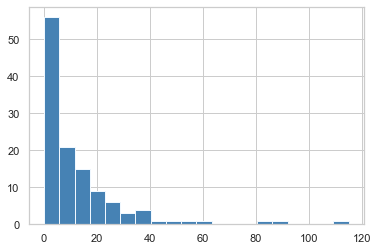

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Cortland-New York
15.308673505457724 19.527027049587534 0.33073354890083 117.94372205878491


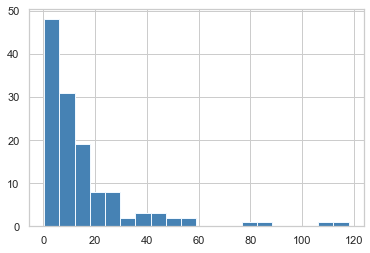

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Delaware-New York
17.775825001010578 24.417462686198387 0.1666926048671454 127.81222524290415


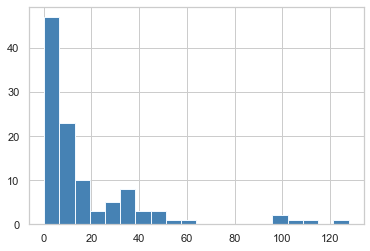

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Hancock-Maine' 'Jefferson-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Orange-Vermont' 'Orleans-New York'
 'Oswego-New York' 'Sagadahoc-Maine' 'Sullivan-New Hampshire'
 'Washington-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Dukes-Massachusetts
15.465483500720612 19.41291972230711 0.3341444334104876 115.04194339855341


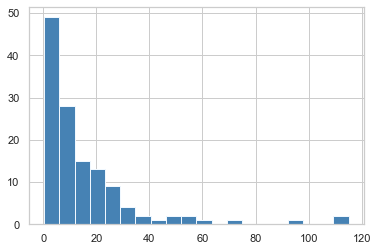

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Dutchess-New York
11.567855344502256 13.821748318244584 0.2917658258752169 72.27854100189319


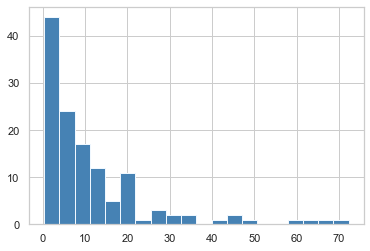

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York']
--------------- 
 Erie-New York
15.179577989613495 19.762590081063813 0.3587203607767011 118.82696956747625


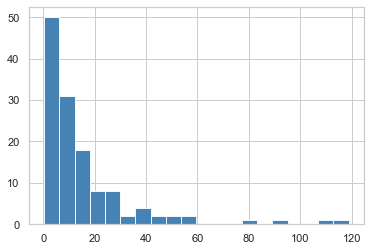

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Essex-Massachusetts
11.880874764537666 13.317647914031381 0.23042809683211313 66.68459469656145


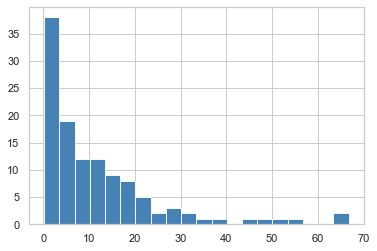

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Wyoming-New York']
--------------- 
 Essex-New York
19.134744737733236 27.641839225774717 0.11797962514096813 191.27870933707902


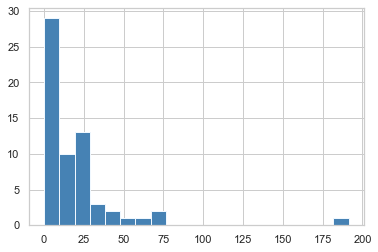

['Hampshire-Massachusetts' 'Jefferson-New York' 'Lincoln-Maine'
 'Merrimack-New Hampshire' 'Orange-Vermont' 'Rutland-Vermont'
 'Sullivan-New Hampshire' 'Washington-Vermont' 'Wayne-New York'
 'Cleburne-Alabama']
--------------- 
 Fairfield-Connecticut
11.40425160600617 13.762693300985465 0.2852100556220078 72.15407013027844


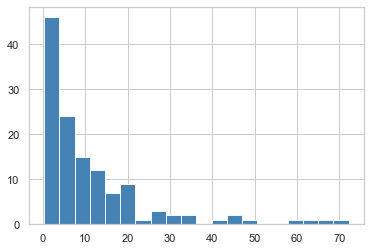

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York']
--------------- 
 Franklin-Massachusetts
24.044033825670066 42.90797131657344 1.5219945879246912 261.2761140391311


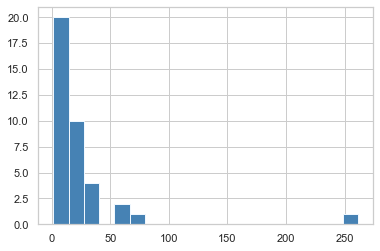

['Orange-Vermont' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Cleburne-Alabama']
--------------- 
 Franklin-New York
13.454454767379275 19.955392338698307 0.12966752995600794 126.78089787088321


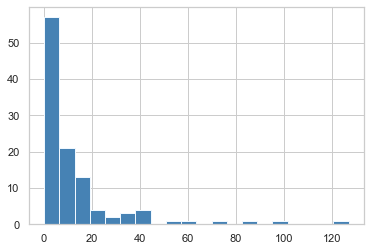

['Chenango-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Genesee-New York' 'Montgomery-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Fulton-New York
15.468240332341951 20.391953183952282 0.35248700207051226 122.85623863511533


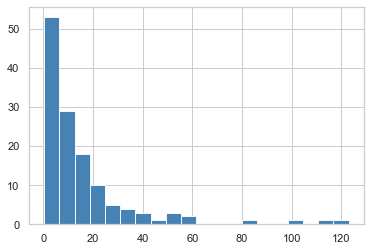

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Steuben-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Genesee-New York
11.312230474341195 13.793830706279673 0.29214216061856374 74.30995310193207


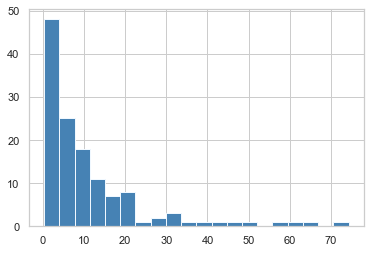

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Schenectady-New York' 'Sullivan-New Hampshire' 'Wyoming-New York']
--------------- 
 Greene-New York
13.407232775332373 17.308875692301424 0.15544494857740382 102.73864381584904


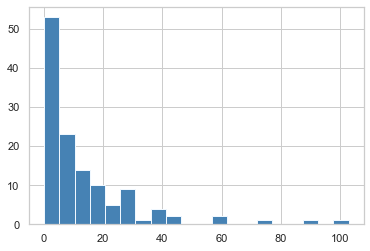

['Chenango-New York' 'Coos-New Hampshire' 'Genesee-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Oneida-New York'
 'Orleans-New York' 'Oswego-New York' 'Rensselaer-New York'
 'Sagadahoc-Maine' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Hamilton-New York
16.306372110144867 20.801683435902998 0.25222556997872175 112.6889127454734


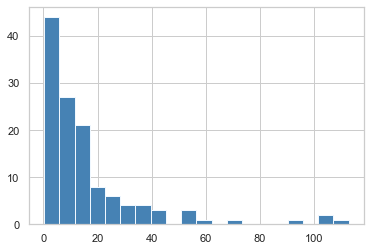

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Jefferson-New York' 'Montgomery-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Hampden-Massachusetts
11.57010121425436 13.662945882396885 0.22328195878332685 71.99195302813551


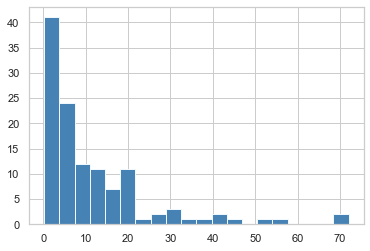

['Allegany-New York' 'Cattaraugus-New York' 'Chemung-New York'
 'Chenango-New York' 'Coos-New Hampshire' 'Genesee-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Wyoming-New York']
--------------- 
 Hampshire-Massachusetts
21.679549263713486 29.404611575312295 0.560048915744529 141.39076327655042


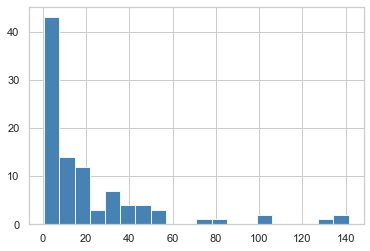

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Lincoln-Maine' 'Madison-New York' 'Penobscot-Maine' 'Rutland-Vermont'
 'Somerset-Maine' 'Steuben-New York' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Hartford-Connecticut
15.114663649563283 19.570901102157965 0.3550253748933992 119.33427048943395


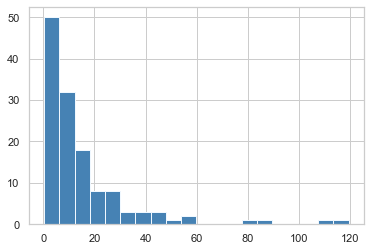

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Herkimer-New York
15.569374906686436 20.472396761438752 0.3385403023880455 120.4655286132556


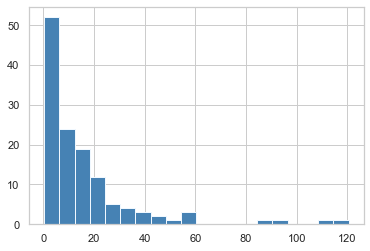

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Jefferson-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Steuben-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Jefferson-New York
13.446544098835712 20.480186604413852 0.15330758301353745 130.24758450255592


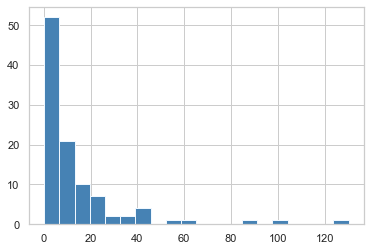

['Chenango-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Lewis-New York
11.355481587046517 13.383663917322213 0.24882658671953428 75.698501304333


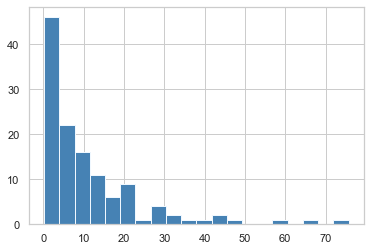

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Wyoming-New York']
--------------- 
 Litchfield-Connecticut
16.57966340711634 21.556870462182232 0.21174127274638593 110.57199228924925


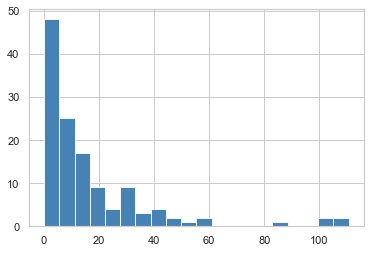

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Lincoln-Maine'
 'Montgomery-New York' 'Orleans-New York' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Washington-Vermont' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Livingston-New York
9.938660770138249 13.36752691773488 0.18952313606120216 78.74998735791647


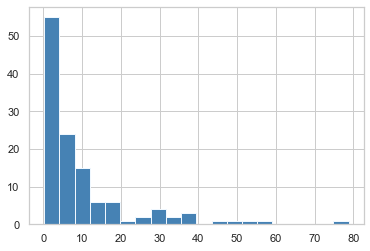

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Wyoming-New York' 'York-Maine'
 'Cleburne-Alabama']
--------------- 
 Madison-New York
10.221443157417381 13.320226308328909 0.18827825377539079 78.03937496963387


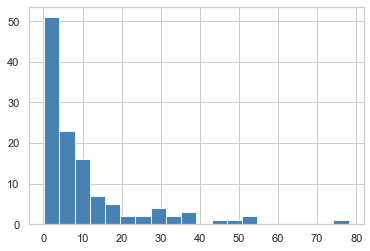

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'York-Maine' 'Cleburne-Alabama']
--------------- 
 Middlesex-Connecticut
13.36079999648633 17.315235991271184 0.1643185641181066 104.67530966841237


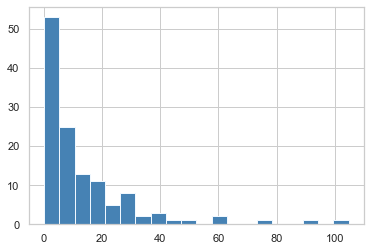

['Cattaraugus-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Oswego-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Middlesex-Massachusetts
15.663099174741067 20.08933831891177 0.23065987933674778 108.29902329743146


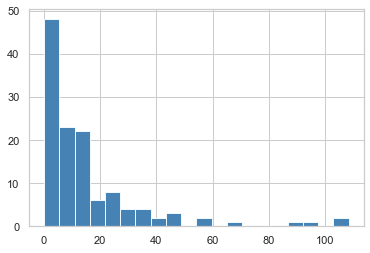

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Jefferson-New York' 'Montgomery-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Washington-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Monroe-New York
15.040954832932636 19.588926071209045 0.3540530272750828 118.7228105042704


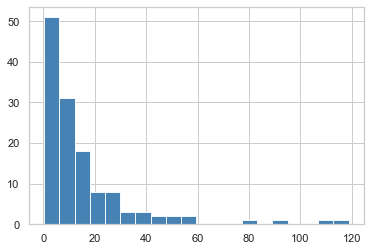

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Montgomery-New York
14.929820038810064 19.522910940937876 0.35123920583526363 121.85100742324833


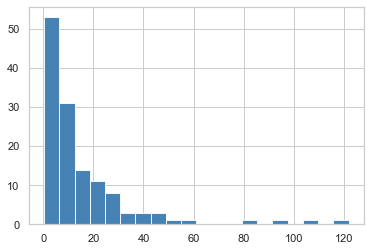

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Oneida-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Nantucket-Massachusetts
14.288175743648313 17.344022366645174 0.2724862225176896 111.66960316652089


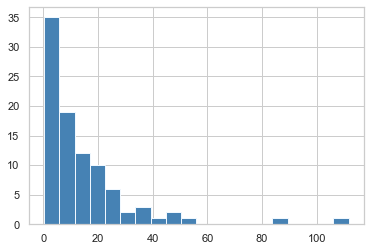

['Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Fairfield-Connecticut' 'Hampden-Massachusetts' 'Montgomery-New York'
 'Rensselaer-New York' 'Strafford-New Hampshire' 'Washington-Rhode Island'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Nassau-New York
11.70614773332104 11.714716949739946 0.1298908036195156 54.09690939317499


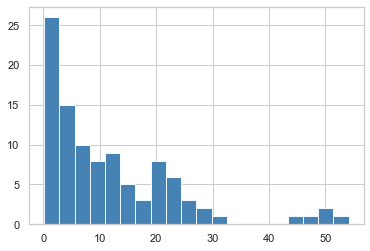

['Chautauqua-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampden-Massachusetts' 'Herkimer-New York' 'Middlesex-New Jersey'
 'Montgomery-New York' 'Onondaga-New York' 'Rensselaer-New York'
 'Somerset-New Jersey' 'Suffolk-Massachusetts' 'Windham-Connecticut'
 'Wyoming-New York' 'York-Maine']
--------------- 
 New Haven-Connecticut
11.329497646710903 13.645093398582887 0.2633811317031163 75.35218051388172


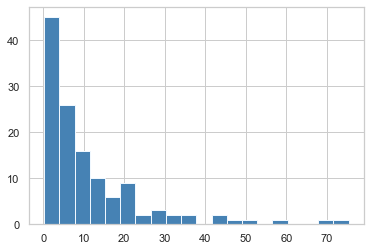

['Allegany-New York' 'Cattaraugus-New York' 'Chemung-New York'
 'Chenango-New York' 'Coos-New Hampshire' 'Genesee-New York'
 'Hampden-Massachusetts' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Schenectady-New York'
 'Wyoming-New York']
--------------- 
 New London-Connecticut
15.519267774383314 20.398216220998048 0.28371560760446823 114.06672849281462


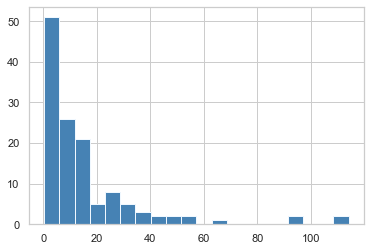

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 New York City-New York
0.6138265134935507 0.5047507408941095 0.0702956371918889 1.4847417579467141


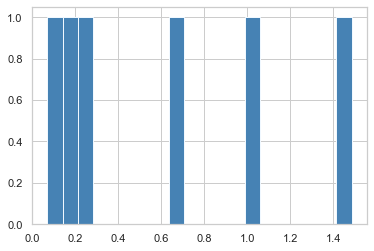

[]
--------------- 
 Niagara-New York
15.08657843150512 19.582796834102698 0.35601827525011975 118.78574354619474


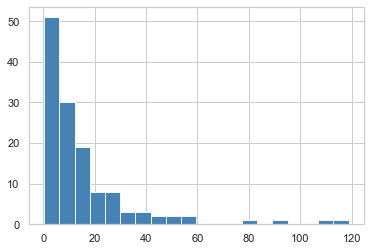

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Norfolk-Massachusetts
13.371704687288158 17.190174873867022 0.16111274485196733 102.15829231067708


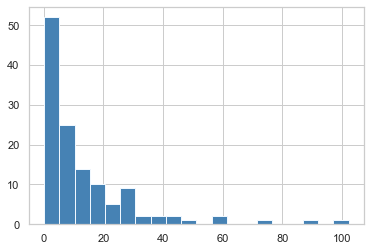

['Chenango-New York' 'Coos-New Hampshire' 'Genesee-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Oneida-New York'
 'Orleans-New York' 'Oswego-New York' 'Rensselaer-New York'
 'Sagadahoc-Maine' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Oneida-New York
11.349483379909316 13.787247778170993 0.29041891280529614 72.51767358942668


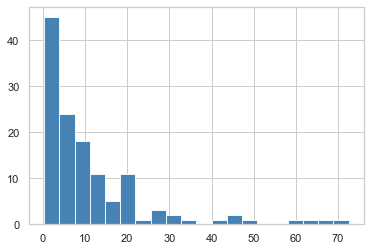

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Madison-New York' 'Monroe-New York' 'Montgomery-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Schenectady-New York' 'Suffolk-Massachusetts' 'Sullivan-New Hampshire'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Onondaga-New York
15.537945178114459 20.40862547263763 0.3238149144624991 121.12292852939468


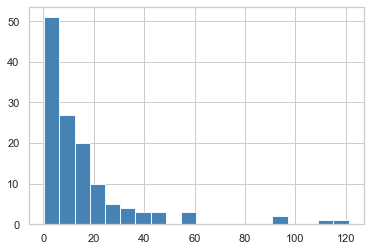

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Steuben-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Ontario-New York
13.57184064348629 17.897052405678664 0.16121071909767376 114.66716902013998


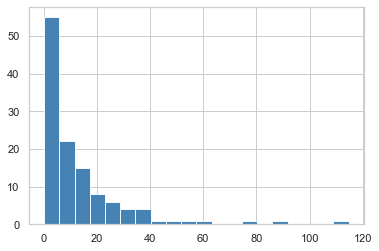

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Orange-New York
13.192999156963683 17.688035503757593 0.36139642087172474 103.84313099319114


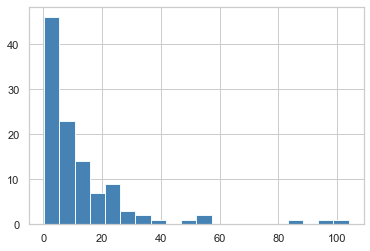

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampden-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Rensselaer-New York'
 'Washington-Rhode Island' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Orleans-New York
15.437976654068455 20.028102305928492 0.2697216363863206 109.9300520736945


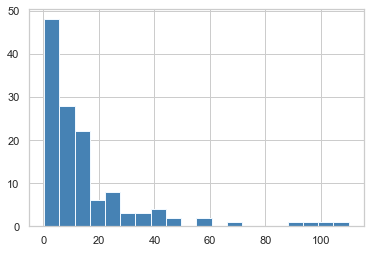

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Washington-Vermont' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Oswego-New York
13.399955885803806 17.415126415512745 0.1514575119581034 104.24973783738986


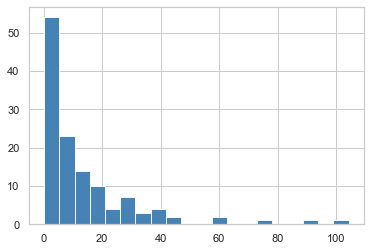

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Sagadahoc-Maine' 'Somerset-Maine' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Otsego-New York
13.42735130940447 20.35920465980985 0.14806038772358265 129.594221213487


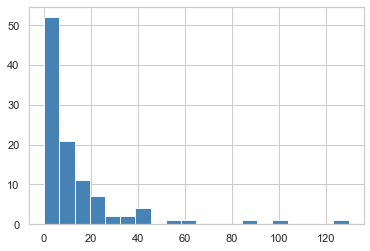

['Chenango-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Plymouth-Massachusetts
15.112926521228726 19.555101187342284 0.35662917443847897 119.06436019746998


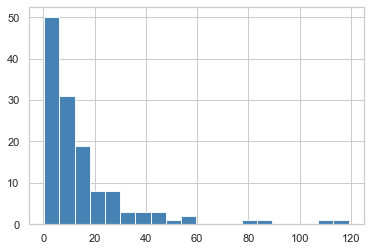

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Putnam-New York
11.31554972163076 13.637740405262095 0.1955857658897024 77.18242603479463


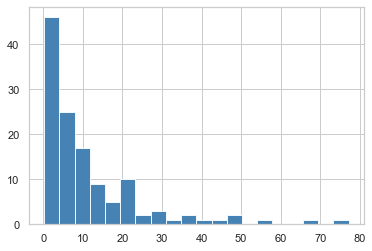

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Schenectady-New York' 'Wyoming-New York']
--------------- 
 Rensselaer-New York
13.217425689245767 17.24693173468499 0.16265530648525792 103.5338039500289


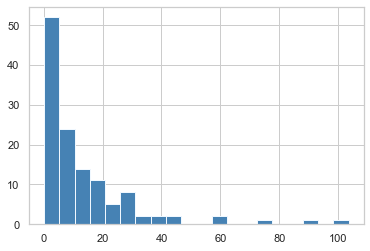

['Cattaraugus-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Oswego-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Rockland-New York
11.912712278243571 11.82123157221682 0.12842744918867993 54.72169756081405


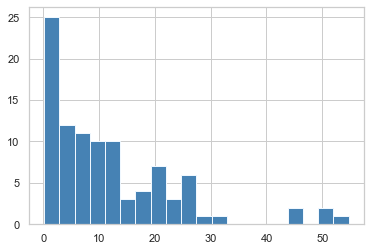

['Albany-New York' 'Atlantic-New Jersey' 'Bristol-Massachusetts'
 'Chautauqua-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Essex-Massachusetts' 'Genesee-New York' 'Hampden-Massachusetts'
 'Montgomery-New York' 'Oneida-New York' 'Rensselaer-New York'
 'Somerset-New Jersey']
--------------- 
 Saratoga-New York
10.09090545496059 13.233059366422193 0.19074617796585888 76.83652982132585


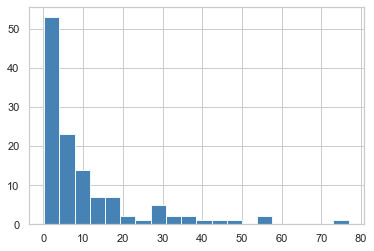

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Genesee-New York' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Montgomery-New York' 'Oneida-New York'
 'Onondaga-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'York-Maine' 'Cleburne-Alabama']
--------------- 
 Schenectady-New York
15.611347913630848 20.37551783683039 0.3189609805829776 119.53557016177741


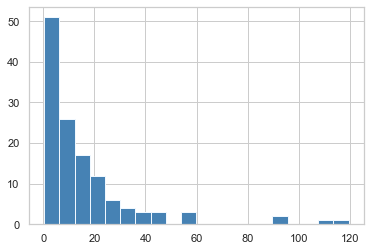

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Steuben-New York' 'Sullivan-New Hampshire'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Schoharie-New York
22.438422225941352 31.209217468530607 0.1788979294123582 144.53644932883103


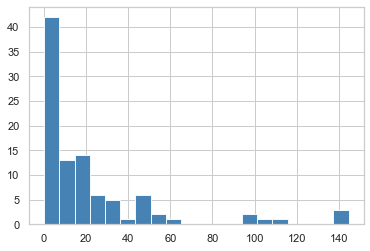

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Schuyler-New York
13.623728258230638 20.110603943567295 0.06304080357031126 131.27232885372564


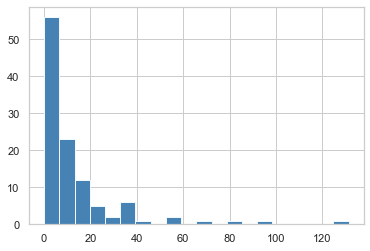

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Hampshire-Massachusetts' 'Madison-New York'
 'Montgomery-New York' 'Onondaga-New York' 'Oswego-New York'
 'Sullivan-New Hampshire' 'Wayne-New York' 'Wyoming-New York' 'York-Maine'
 'Cleburne-Alabama']
--------------- 
 Seneca-New York
13.22957695662632 19.528104283977356 0.1720967288623634 118.02597108228609


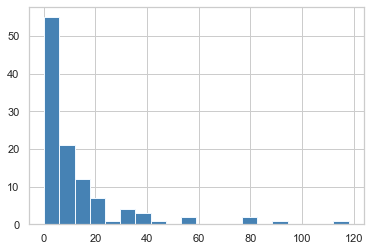

['Chenango-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 St. Lawrence-New York
13.453957478771681 17.816916109672395 0.16101803884070698 115.37379791554028


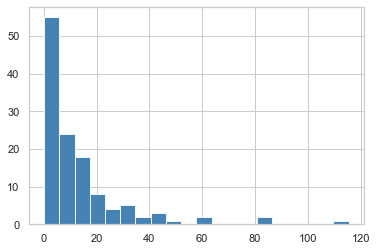

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Fulton-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Oneida-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Wayne-New York' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Steuben-New York
15.681388332585307 20.268105605639242 0.22840121709486425 106.63643364753649


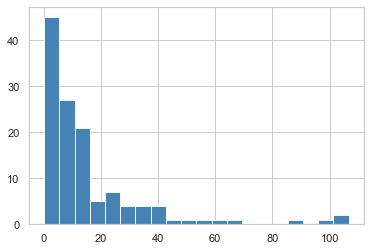

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Montgomery-New York' 'Sullivan-New Hampshire'
 'Washington-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Suffolk-Massachusetts
11.531915615931961 13.718117548345171 0.2129929511929172 72.16166629969851


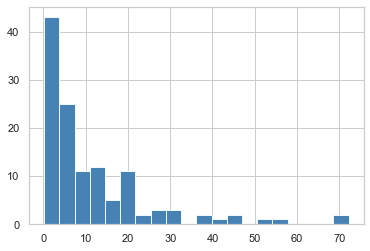

['Allegany-New York' 'Cattaraugus-New York' 'Chemung-New York'
 'Chenango-New York' 'Coos-New Hampshire' 'Genesee-New York'
 'Hampden-Massachusetts' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Schenectady-New York'
 'Wyoming-New York' 'York-Maine']
--------------- 
 Suffolk-New York
11.795884225677476 11.680306846145923 0.13016979417938623 54.30568105337932


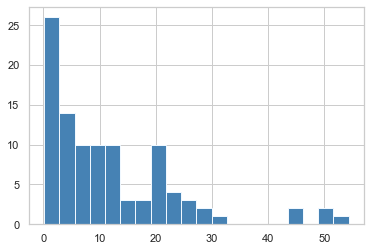

['Chautauqua-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampden-Massachusetts' 'Montgomery-New York' 'Rensselaer-New York'
 'Somerset-New Jersey' 'Suffolk-Massachusetts']
--------------- 
 Sullivan-New York
15.117910677950057 19.550572630022796 0.3566601829235581 118.48209945475682


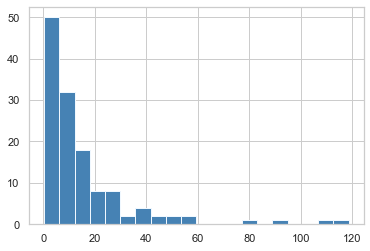

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Tioga-New York
15.546998355030931 20.11474730735906 0.24353095371878142 107.88402285186329


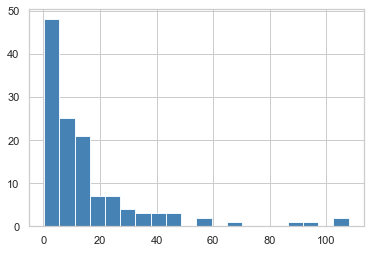

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Genesee-New York' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Montgomery-New York' 'Oneida-New York' 'Onondaga-New York'
 'Orleans-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Tolland-Connecticut
17.95051475885164 24.679124712560224 0.17361585917409833 132.02285824242972


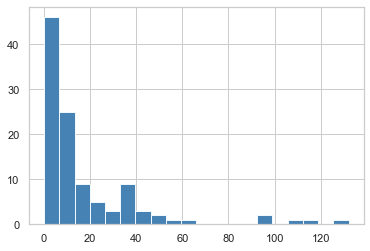

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Franklin-Massachusetts' 'Fulton-New York' 'Hampshire-Massachusetts'
 'Jefferson-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Orange-Vermont' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Windham-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Tompkins-New York
25.21819693189581 37.63650576769518 0.26425618884520813 221.15895582945174


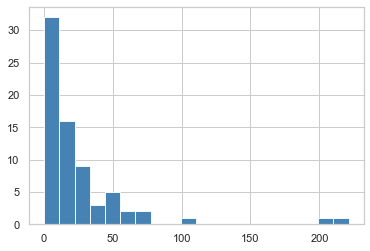

['Coos-New Hampshire' 'Cumberland-Maine' 'Franklin-Massachusetts'
 'Lincoln-Maine' 'Orange-Vermont' 'Rensselaer-New York'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Waldo-Maine'
 'Cleburne-Alabama']
--------------- 
 Ulster-New York
15.674755658351692 20.10322068168097 0.22995798568227663 108.13439887152201


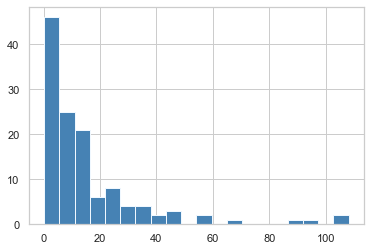

['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampshire-Massachusetts' 'Jefferson-New York' 'Montgomery-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Washington-Vermont' 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Warren-New York
13.434173573220772 20.19389636975516 0.12245970636643537 129.88043921812408


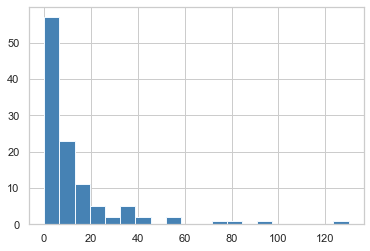

['Chenango-New York' 'Coos-New Hampshire' 'Fulton-New York'
 'Hampshire-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Onondaga-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Washington-New York
23.24020883645336 32.459388557368506 0.29210782560673404 155.9703872352681


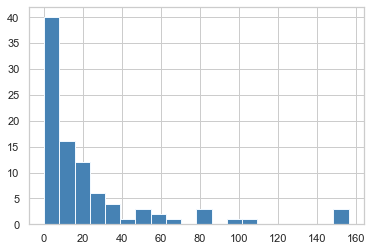

['Chenango-New York' 'Lincoln-Maine' 'Orange-Vermont' 'Orleans-New York'
 'Rensselaer-New York' 'Wyoming-New York']
--------------- 
 Wayne-New York
13.386826343422639 18.104693143325633 0.16218717457294177 116.6155724671758


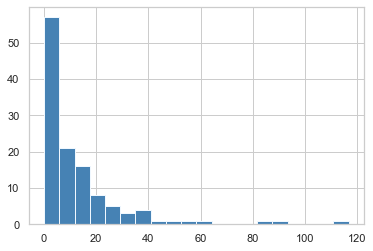

['Chemung-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Genesee-New York' 'Hampshire-Massachusetts' 'Herkimer-New York'
 'Montgomery-New York' 'Orleans-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Wyoming-New York' 'Cleburne-Alabama']
--------------- 
 Westchester-New York
11.037015986341974 11.5416426971309 0.13146082121282468 55.6842599226124


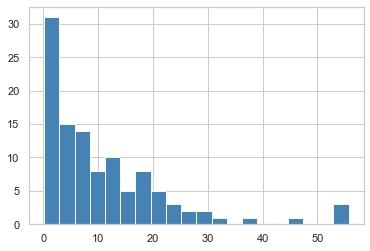

['Chautauqua-New York' 'Chenango-New York' 'Clinton-New York'
 'Coos-New Hampshire' 'Fairfield-Connecticut' 'Genesee-New York'
 'Hampden-Massachusetts' 'Herkimer-New York' 'Montgomery-New York'
 'Onondaga-New York' 'Rensselaer-New York' 'Schenectady-New York'
 'Wyoming-New York']
--------------- 
 Windham-Connecticut
15.10379999391724 19.525269399510112 0.3558210191821249 118.92333790070698


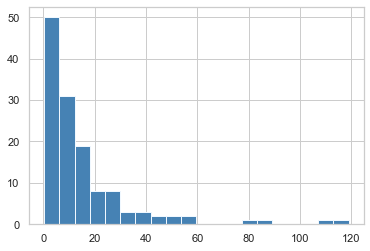

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Worcester-Massachusetts
15.042600297169733 19.496828957931264 0.35215765384969283 118.47113319588934


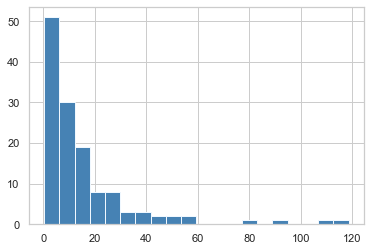

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Rensselaer-New York' 'Somerset-Maine'
 'Steuben-New York' 'Sullivan-New Hampshire' 'Wyoming-New York'
 'Cleburne-Alabama']
--------------- 
 Wyoming-New York
15.15669356302046 19.31111433141239 0.3287722463585128 118.97302673599499


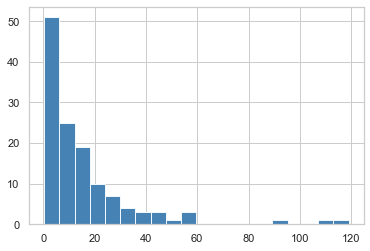

['Allegany-New York' 'Cattaraugus-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oneida-New York' 'Onondaga-New York' 'Orleans-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Steuben-New York'
 'Sullivan-New Hampshire' 'Cleburne-Alabama']
--------------- 
 Yates-New York
26.651677873187477 39.629908243105156 0.1576553829855521 219.94219819810942


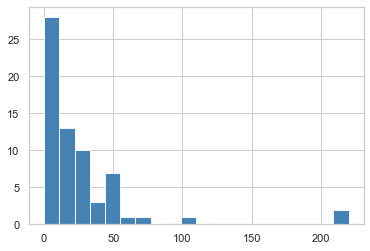

['Coos-New Hampshire' 'Cumberland-Maine' 'Orange-Vermont'
 'Rensselaer-New York' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Waldo-Maine' 'Cleburne-Alabama']


In [42]:
from pyod.models.hbos import HBOS

warnings.filterwarnings("ignore")

#df = df[df.columns[(df>100).any()]].copy()
start_date = '2021-08-01'
low_thresh_date = '2021-10-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)


plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []
TP = 0
FP = 0

#outliers = set(['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas'])
outliers = set(['Winston-Alabama', 'Cleburne-Alabama', 'Cherokee-Alabama', 'Gaines-Texas','Newton-Texas', 'Motley-Texas'])
i=1
for state in targets:
    # otherStates = donors.copy()
    rscModel = get_pre_filter(state, singVals, high_thresh, low_thresh)
    
    '''
    therStates = list(target_donors[state])
    
    orig_model =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        orig_model.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
    '''    
    perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
    train_perm_dict = permutation_train_test(rscModel)
    train_values = np.array(list(perm_dict.values()))
    
    test_perm_dict = permutation_train_test(rscModel, train_err = False)
    test_values = np.array(list(perm_dict.values()))

    all_donors = np.array(list(perm_dict.keys()))
    values = np.array(list(perm_dict.values()))
    
    # show histogram
    print('--------------- \n',state)
    print(values.mean(), values.std(), min(values), max(values))
    fig, ax = plt.subplots(1,1, figsize = (6, 4))
    ax.hist(values, bins = 20, facecolor='steelblue', edgecolor='aliceblue')
    plt.show()
    
    ################################################
    ################################################
    # HBOS
    input_df =  pd.DataFrame(values)
    hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
    hbos.fit(input_df)
    output = hbos.decision_function(input_df)
    res = hbos.predict(input_df)
    res = np.array(res, dtype = bool)
    print(all_donors[res])
    if set(all_donors[res]) == set(outliers):
        print('found best match!')
        break
    for item in all_donors[res]:
        if item in outliers:
            TP+=1
        else:
            FP+=1
    
    ################################################
    ################################################
    
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(all_donors[~res]))
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    '''
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    '''
    
    target_counties2.append(state)
    
    

In [25]:
print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[94.9656229297011, 291.68766765445645, 23.92766998761023, 1217.8836289038666, 1349.3451201499822, 447.7029709229771, 407.91477877777726, 0.3276706126486287, 12.097683659301326, 81.24409148730159, 6.70855190890534, 18.527130307328637, 170.5946669699003, 17.242044483233435], [94.9656229297011, 217.07487968766085, 23.92766998761023, 1187.086899154151, 1349.3451201499822, 16.43396976841253, 411.5418707406735, 0.0, 22.868959981030766, 72.863408151468, 15.983497345408079, 1.70956084649274, 224.60621842120267, 17.80574517321998], []]
__________________
__________________
training MSE:
 [[32.15332597431972, 52.68732471501622, 6.873447681558162, 23.747706447860928, 166.62109696419867, 216.3196236687485, 45.06954436274584, 24.043537806082515, 1.791496150855984, 3.808354928723047, 69.20517556722464, 11.50283526517649, 55.39653640232568, 32.51173160837597], [32.15332597431972, 62.286902336191844, 6.873447681558162, 17.996843863688063, 166.62109696419867, 195.45461211009953, 67.12640539

### two-dimension HBO

--------------- 
 Albany-New York
9.628186523529084 13.894634235223023 0.06670400817299611


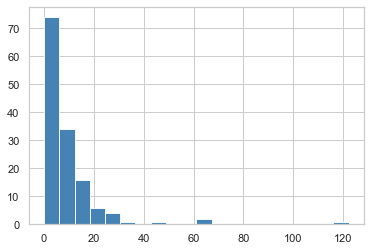

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Allegany-New York
11.563605998169036 15.677510268027268 0.40743559530598367


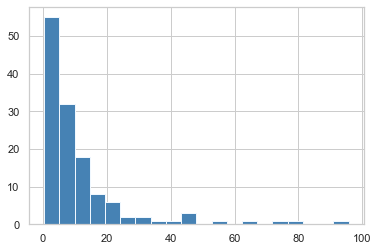

outliers: ['Bristol-Rhode Island' 'Chenango-New York' 'Coos-New Hampshire'
 'Cumberland-Maine' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oneida-New York'
 'Oxford-Maine' 'Rensselaer-New York' 'Somerset-Maine'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Maine' 'Washington-Rhode Island' 'Washington-Vermont'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Barnstable-Massachusetts
10.307935073645915 15.876055777709045 0.11652670741719635


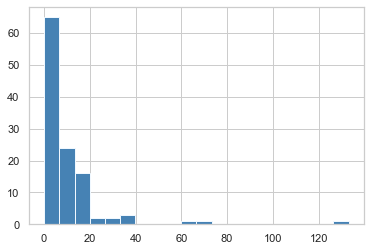

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Orange-Vermont' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Washington-Rhode Island' 'Wyoming-New York']
--------------- 
 Berkshire-Massachusetts
11.940289514467542 17.781878272540837 0.419965909920233


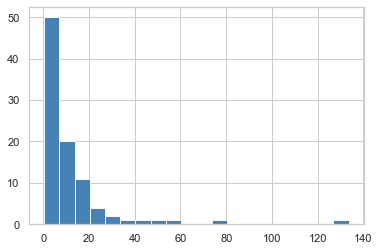

outliers: ['Caledonia-Vermont' 'Chenango-New York' 'Cumberland-Maine'
 'Jefferson-New York' 'Kennebec-Maine' 'Lincoln-Maine' 'Orange-Vermont'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Washington-Vermont' 'Wayne-New York']
--------------- 
 Bristol-Massachusetts
9.087619385374234 12.535076472178089 0.4098865505463478


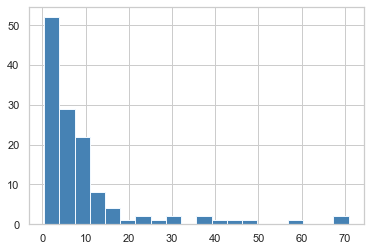

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oxford-Maine' 'Somerset-Maine' 'Somerset-New Jersey'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Washington-New York'
 'Wayne-New York' 'Wyoming-New York' 'York-Maine']
--------------- 
 Broome-New York
14.493636798882678 17.588508099739453 0.2801887494862507


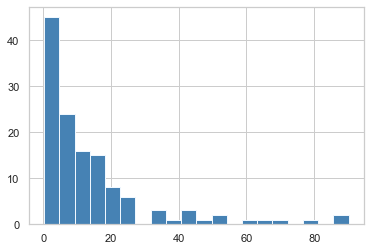

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Cumberland-Maine' 'Essex-Massachusetts' 'Hampden-Massachusetts'
 'Hampshire-Massachusetts' 'Jefferson-New York' 'Montgomery-New York'
 'Oxford-Maine' 'Rensselaer-New York' 'Somerset-Maine'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Cattaraugus-New York
9.381049377636094 14.022943345801703 0.32356510712642617


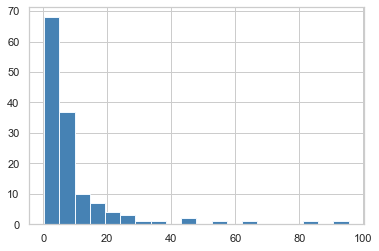

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Cayuga-New York
9.53721961435228 14.116542571063412 0.3853784053530153


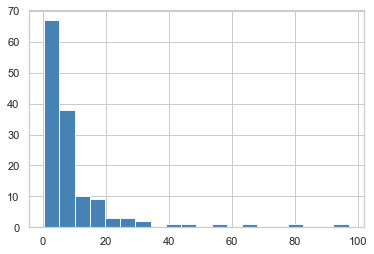

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Chautauqua-New York
9.75213405967215 14.499377135919657 0.2779636853716931


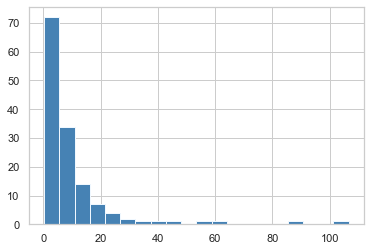

outliers: ['Allegany-New York' 'Aroostook-Maine' 'Bristol-Rhode Island'
 'Caledonia-Vermont' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Jefferson-New York' 'Knox-Maine' 'Lincoln-Maine'
 'Montgomery-New York' 'Oxford-Maine' 'Rensselaer-New York'
 'Somerset-Maine' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Washington-Rhode Island' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Chemung-New York
9.128794626978586 12.720713588197828 0.5208021728185827


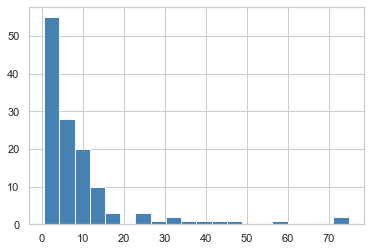

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oxford-Maine' 'Somerset-Maine' 'St. Lawrence-New York'
 'Sullivan-New Hampshire' 'Washington-New York' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Chenango-New York
12.429093772534666 18.327966380349718 0.3359904648039307


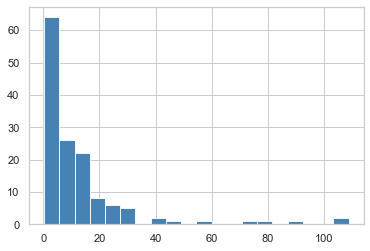

outliers: ['Allegany-New York' 'Aroostook-Maine' 'Bristol-Rhode Island'
 'Caledonia-Vermont' 'Coos-New Hampshire' 'Cumberland-Maine'
 'Herkimer-New York' 'Jefferson-New York' 'Lincoln-Maine'
 'Montgomery-New York' 'Oneida-New York' 'Oxford-Maine'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Washington-Maine' 'Washington-Vermont' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Clinton-New York
10.011738219157088 15.093122465722274 0.08030832495542307


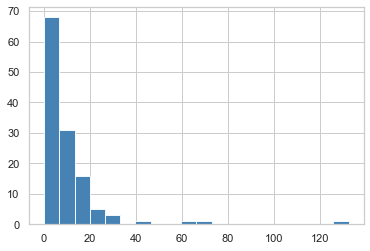

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Union-New Jersey' 'Washington-Rhode Island' 'Wyoming-New York']
--------------- 
 Columbia-New York
10.168202085136818 15.59687107369965 0.08877841292911377


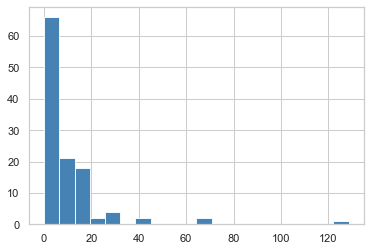

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Orange-Vermont' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wyoming-New York']
--------------- 
 Cortland-New York
9.505675928923171 14.055209501554348 0.27198774574344814


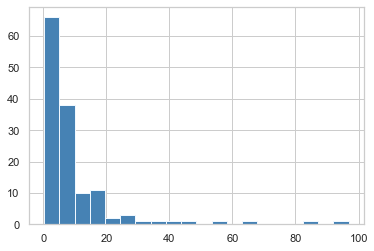

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Delaware-New York
9.487460664744214 13.973541111652898 0.1539250827038727


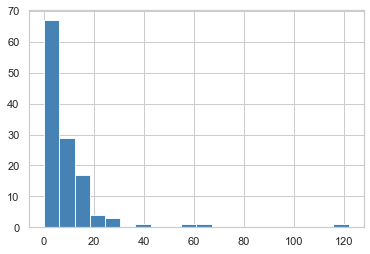

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Piscataquis-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Union-New Jersey' 'Wyoming-New York']
--------------- 
 Dukes-Massachusetts
9.733051002727548 13.049267329827005 0.06748849886709056


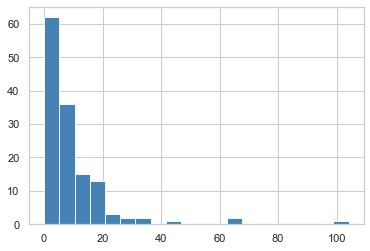

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Washington-Rhode Island' 'Wyoming-New York']
--------------- 
 Dutchess-New York
9.492450787952304 14.036329572391285 0.33098261832757403


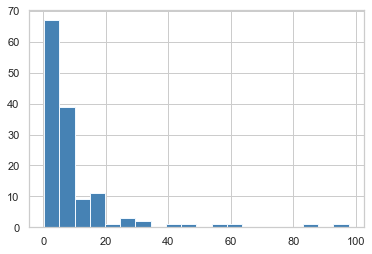

outliers: ['Allegany-New York' 'Caledonia-Vermont' 'Chemung-New York'
 'Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Hampden-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Kennebec-Maine' 'Kent-Rhode Island' 'Merrimack-New Hampshire'
 'Montgomery-New York' 'Piscataquis-Maine' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Warren-New York' 'Washington-New York'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Erie-New York
9.556652814379227 14.303635798675517 0.342808692611468


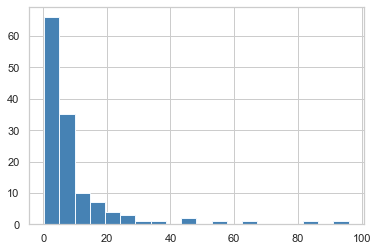

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Essex-Massachusetts
9.029847925928875 12.531858471016843 0.4228622983995933


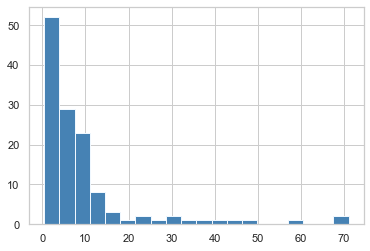

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'Somerset-New Jersey' 'St. Lawrence-New York'
 'Sullivan-New Hampshire' 'Washington-New York' 'Wayne-New York'
 'Wyoming-New York' 'York-Maine']
--------------- 
 Essex-New York
16.74199551330805 18.91198090041109 0.5056751990437143


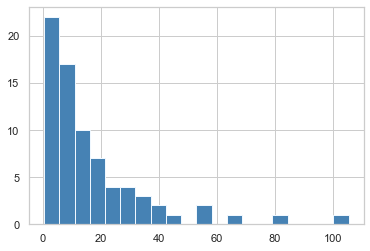

outliers: ['Columbia-New York' 'Cumberland-Maine' 'Hampshire-Massachusetts'
 'Jefferson-New York' 'Kennebec-Maine' 'Lincoln-Maine' 'Orange-Vermont'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wayne-New York']
--------------- 
 Fairfield-Connecticut
9.46793852768801 13.731233355926676 0.2000775628813648


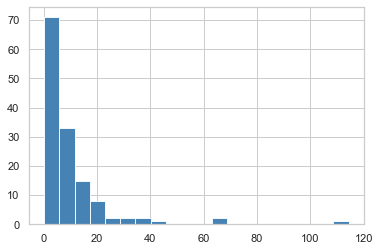

outliers: ['Allegany-New York' 'Aroostook-Maine' 'Bristol-Rhode Island'
 'Caledonia-Vermont' 'Chemung-New York' 'Chenango-New York'
 'Herkimer-New York' 'Jefferson-New York' 'Lincoln-Maine'
 'Montgomery-New York' 'Oneida-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Franklin-Massachusetts
14.209989188053033 13.213254499374306 1.5352013659489636


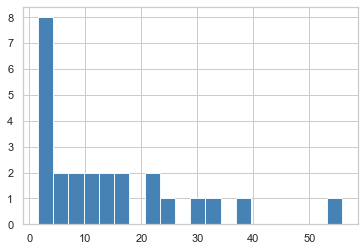

outliers: ['Cumberland-Maine']
--------------- 
 Franklin-New York
9.692321576630707 14.048589880961941 0.06700266668541156


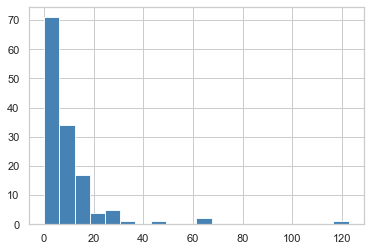

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Fulton-New York
14.423585715266285 17.539880258131877 0.2893785935285736


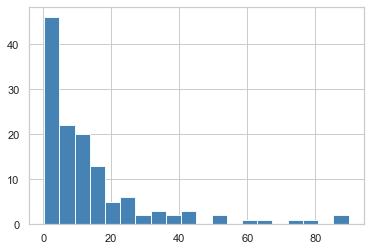

outliers: ['Allegany-New York' 'Caledonia-Vermont' 'Chenango-New York'
 'Coos-New Hampshire' 'Cumberland-Maine' 'Essex-Massachusetts'
 'Hampden-Massachusetts' 'Hampshire-Massachusetts' 'Jefferson-New York'
 'Montgomery-New York' 'New London-Connecticut' 'Oxford-Maine'
 'Rensselaer-New York' 'Somerset-Maine' 'St. Lawrence-New York'
 'Sullivan-New Hampshire' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Genesee-New York
9.120851208176864 12.629296756739514 0.43899541339997106


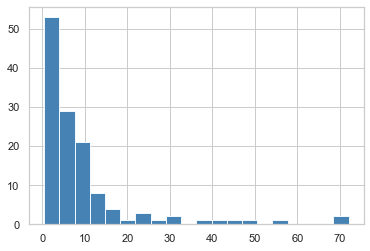

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oxford-Maine' 'Somerset-Maine' 'Somerset-New Jersey'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Washington-New York'
 'Wayne-New York' 'Wyoming-New York' 'York-Maine']
--------------- 
 Greene-New York
9.970750358769665 14.310139831667518 0.06893627467291664


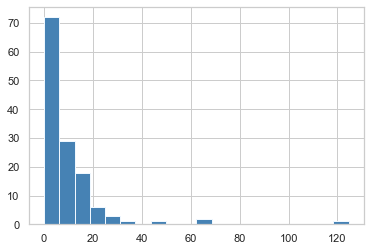

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Hamilton-New York
13.536807164221281 18.37579691771898 0.285886984319954


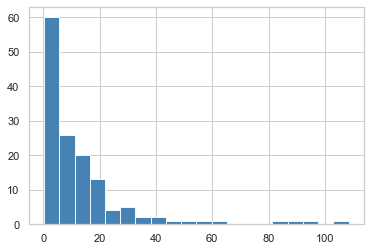

outliers: ['Allegany-New York' 'Caledonia-Vermont' 'Chenango-New York'
 'Coos-New Hampshire' 'Cumberland-Maine' 'Hampden-Massachusetts'
 'Jefferson-New York' 'Lincoln-Maine' 'Montgomery-New York'
 'Oneida-New York' 'Orange-Vermont' 'Oxford-Maine' 'Rensselaer-New York'
 'Somerset-Maine' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Union-New Jersey' 'Washington-Vermont' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Hampden-Massachusetts
9.105998039502344 12.593048819225599 0.37012242122593186


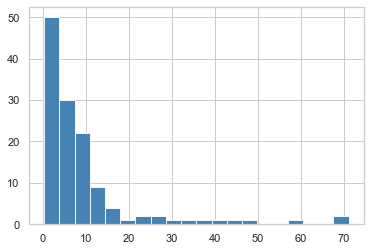

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Essex-Massachusetts'
 'Herkimer-New York' 'Jefferson-New York' 'Montgomery-New York'
 'Oxford-Maine' 'Somerset-Maine' 'Somerset-New Jersey'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Washington-New York'
 'Wayne-New York' 'Wyoming-New York' 'York-Maine']
--------------- 
 Hampshire-Massachusetts
18.227929360340507 27.64588045090359 0.21032504129157634


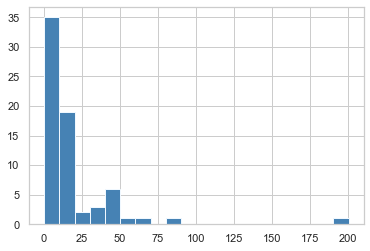

outliers: ['Chenango-New York' 'Cumberland-Maine' 'Franklin-Massachusetts'
 'Hancock-Maine' 'Kennebec-Maine' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Washington-Vermont' 'Wayne-New York']
--------------- 
 Hartford-Connecticut
9.282909329937889 13.458448304651789 0.09340426696783363


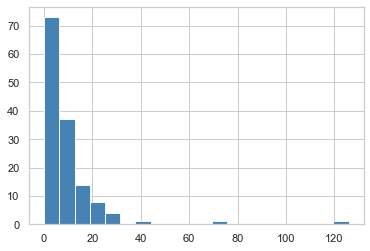

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Hampden-Massachusetts' 'Herkimer-New York' 'Lincoln-Maine'
 'Montgomery-New York' 'Oneida-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Herkimer-New York
9.400952210726928 14.315809836793834 0.3208699585756349


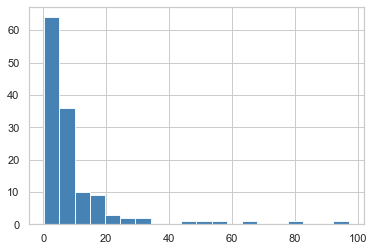

outliers: ['Allegany-New York' 'Aroostook-Maine' 'Bristol-Rhode Island'
 'Caledonia-Vermont' 'Chenango-New York' 'Coos-New Hampshire'
 'Jefferson-New York' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Washington-Rhode Island' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Jefferson-New York
9.943142861512666 14.347738750946883 0.06941105919071158


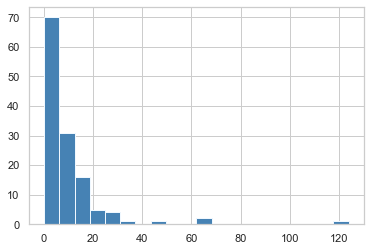

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Lewis-New York
11.155894243844994 15.21476888216694 0.18168653287701841


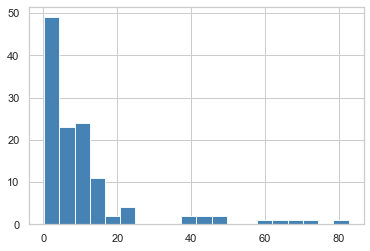

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Cumberland-Maine'
 'Essex-Massachusetts' 'Herkimer-New York' 'Jefferson-New York'
 'Montgomery-New York' 'Oxford-Maine' 'Somerset-Maine'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Washington-New York'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Litchfield-Connecticut
10.475313585769706 14.99854689873604 0.08991909636694868


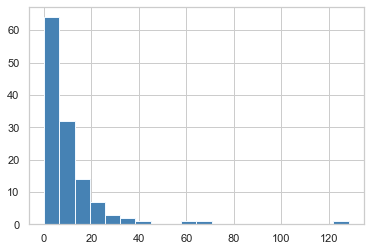

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Hampden-Massachusetts' 'Herkimer-New York' 'Lincoln-Maine'
 'Montgomery-New York' 'Oneida-New York' 'Orange-Vermont' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Union-New Jersey'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Livingston-New York
9.611064380865592 13.790719384193647 0.0672323489818945


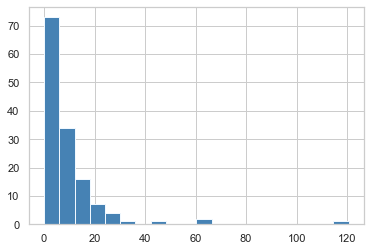

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Oneida-New York'
 'Rensselaer-New York' 'Somerset-Maine' 'Sullivan-New Hampshire'
 'Tioga-New York' 'Washington-Rhode Island' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Madison-New York
9.920662988703604 14.254237015148215 0.0739163125097606


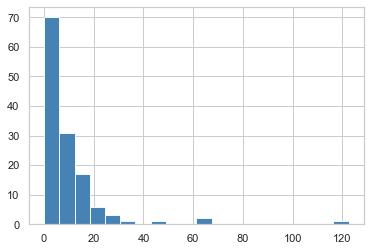

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Middlesex-Connecticut
10.242592599076612 15.68139908961772 0.09595955825335957


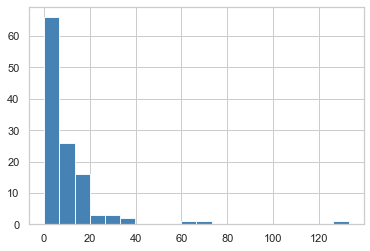

outliers: ['Allegany-New York' 'Chenango-New York' 'Coos-New Hampshire'
 'Herkimer-New York' 'Lincoln-Maine' 'Orange-Vermont' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wyoming-New York']
--------------- 
 Middlesex-Massachusetts
9.876618061409504 14.187029069477912 0.0684465155541654


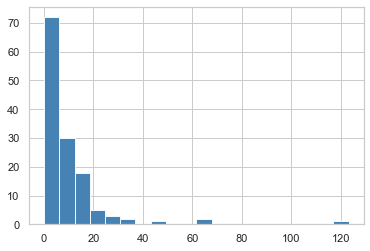

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Somerset-Maine'
 'Sullivan-New Hampshire' 'Tioga-New York' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Monroe-New York
9.416453416874809 14.032455230022585 0.3253667794708702


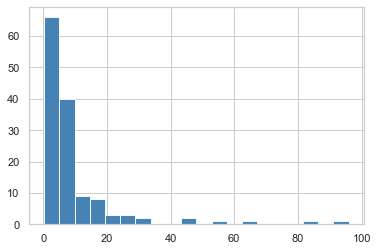

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Washington-Rhode Island'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 Montgomery-New York
14.361447187299577 17.852249794121146 0.31324390934582214


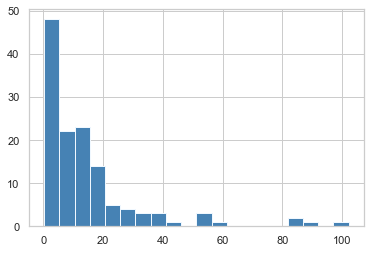

outliers: ['Allegany-New York' 'Aroostook-Maine' 'Caledonia-Vermont'
 'Chenango-New York' 'Coos-New Hampshire' 'Cumberland-Maine'
 'Essex-Massachusetts' 'Hampden-Massachusetts' 'Hampshire-Massachusetts'
 'Jefferson-New York' 'New London-Connecticut' 'Oxford-Maine'
 'Rensselaer-New York' 'Somerset-Maine' 'St. Lawrence-New York'
 'Sullivan-New Hampshire' 'Washington-Vermont' 'Wayne-New York'
 'Wyoming-New York']
--------------- 
 Nantucket-Massachusetts
10.357573317174749 14.107639763628118 0.4031286653306654


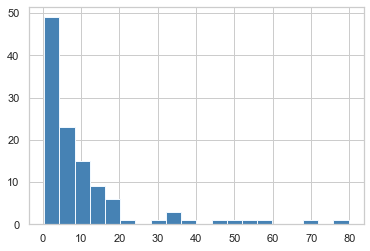

outliers: ['Allegany-New York' 'Bergen-New Jersey' 'Chenango-New York'
 'Coos-New Hampshire' 'Essex-Massachusetts' 'Jefferson-New York'
 'Montgomery-New York' 'Oxford-Maine' 'Somerset-Maine'
 'St. Lawrence-New York' 'Sullivan-New Hampshire' 'Wyoming-New York']
--------------- 
 Nassau-New York
8.8343244411119 11.837308952149419 0.12267362605844076


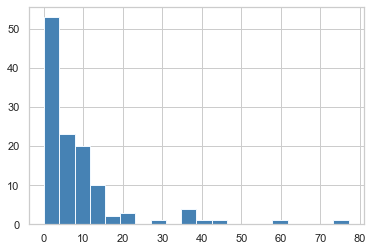

outliers: ['Allegany-New York' 'Bristol-Rhode Island' 'Caledonia-Vermont'
 'Chenango-New York' 'Essex-Massachusetts' 'Herkimer-New York'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'St. Lawrence-New York' 'Sullivan-New Hampshire'
 'Wayne-New York' 'Wyoming-New York']
--------------- 
 New Haven-Connecticut
11.944349991832368 16.482171931350816 0.5027838013693939


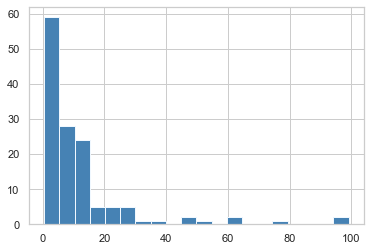

outliers: ['Allegany-New York' 'Chenango-New York' 'Cumberland-Maine'
 'Jefferson-New York' 'Montgomery-New York' 'Oxford-Maine'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Washington-Vermont'
 'Wyoming-New York']
--------------- 
 New London-Connecticut
9.609476118211004 13.897591735943573 0.06671586061502759


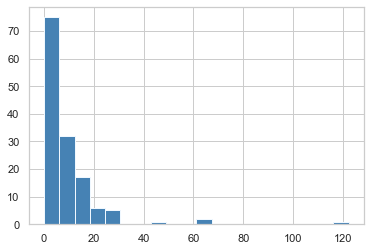

outliers: ['Allegany-New York' 'Chemung-New York' 'Chenango-New York'
 'Coos-New Hampshire' 'Hampden-Massachusetts' 'Herkimer-New York'
 'Lincoln-Maine' 'Montgomery-New York' 'Rensselaer-New York'
 'Somerset-Maine' 'Sullivan-New Hampshire' 'Tioga-New York'
 'Washington-Rhode Island' 'Wayne-New York' 'Wyoming-New York']
--------------- 
 New York City-New York


ValueError: min() arg is an empty sequence

In [43]:
from pyod.models.hbos import HBOS

warnings.filterwarnings("ignore")

#start_date = '2020-04-01'
#low_thresh_date = '2020-06-01'
start_date = '2021-08-01'
low_thresh_date = '2021-10-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)


plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []
TP = 0
FP = 0

#outliers = set(['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas'])
outliers = set(['Winston-Alabama', 'Cleburne-Alabama', 'Cherokee-Alabama', 'Gaines-Texas','Newton-Texas', 'Motley-Texas'])

i=1
for state in targets:
    # otherStates = donors.copy()
    orig_model = get_pre_filter(state, singVals, high_thresh, low_thresh)
    
    otherStates = list(target_donors[state])
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
    train_perm_dict = permutation_train_test(rscModel)
    train_values = np.array(list(perm_dict.values()))
    
    test_perm_dict = permutation_train_test(rscModel, train_err = False)
    test_values = np.array(list(perm_dict.values()))

    all_donors = np.array(list(perm_dict.keys()))
    values = np.array(list(perm_dict.values()))
    
    # show histogram
    print('--------------- \n',state)
    print(values.mean(), values.std(), min(values))
    fig, ax = plt.subplots(1,1, figsize = (6, 4))
    ax.hist(values, bins = 20, facecolor='steelblue', edgecolor='aliceblue')
    plt.show()
    
    ################################################
    ################################################
    # HBOS
    input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
    hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
    hbos.fit(input_df)
    output = hbos.decision_function(input_df)
    res = hbos.predict(input_df)
    res = np.array(res, dtype = bool)
    print('outliers:', all_donors[res])
    for item in all_donors[res]:
        if item in outliers:
            TP+=1
        else:
            FP+=1
    
    ################################################
    ################################################
    
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(all_donors[~res]))
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    
    target_counties2.append(state)
    
    

In [84]:
print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[95.93538104051524, 280.4390643962301, 25.10079771976387, 1228.111863083009, 1070.6111713515663, 421.62493342285796, 661.3552232152343, 0.3435584928683061, 27.09805782674155, 86.99851879905516, 9.640409001524016, 4.561281953431446, 188.7174610561316, 18.703384376173496], [23.899689634934965, 272.03979794222397, 14.27525451836883, 1461.8109290982268, 1070.6111713515663, 16.54593229334493, 186.37470610270637, 0.0, 27.09805782674155, 86.99851879905516, 18.94161127899624, 83.81871725397504, 151.79126800587855, 14.515434422662894], [95.93538104051659, 280.43906439623083, 25.100797719763666, 1228.1118630830117, 1445.726914446395, 421.6249334228572, 347.8296312422247, 0.343558492868301, 12.661869458141382, 86.9985187990551, 6.338751475210288, 18.892791671251207, 169.0939961352803, 18.19599495244166]]
__________________
__________________
training MSE:
 [[32.15332597431976, 52.68732471501626, 6.87344768155814, 23.74770644786093, 197.89840875752475, 216.3196236687488, 54.77664222405

In [85]:
recall = TP/(len(outliers)*len(targets))
precision = TP/(TP+FP)
print(precision, recall)

0.5882352941176471 0.35714285714285715


In [ ]:
'''
########################################################################
# orig error ratio is different from backward donor elimination because
# backward donor elimination only looks at pre-intervention but this one doesn't 
########################################################################

precision, recall = 0.5652173913043478 0.30952380952380953
error ratio orig: 8.377782814358392
error ratio, backward donor elim: 10.08633330141814
error ratio, our method: 7.382689377551733
'''



## Testing the library (Backward Donor Elimination + HBO)

In [ ]:
#df = df[df.columns[(df>100).any()]].copy()
import warnings
warnings.filterwarnings("ignore")

start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []
target_donors = {}
target_detected_outliers ={}
i=1


hi_thresh, lo_thresh = low_thresh, int(low_thresh*.8)
for state in donors:#for state in ['Albany-New York']: #
#otherStates = donors.copy()
    try:
        # TODO: should I replaced low_thresh with 0?
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=otherStates)
    #try:
    rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
    #except Exception as e: 
    #    print(e)
    #    continue

    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    

In [ ]:
print('error ratio:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))


### one dimension HBO

## our donor selection model; Permutation Distribution

In [33]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)



plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []

i=1
for state in targets:
    orig_model = get_pre_filter(state, singVals, high_thresh, low_thresh)

    otherStates = list(target_donors[state])
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel2.fit_model(filter_donor = True, filter_method = 'iqr', singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    
    target_counties2.append(state)
    
    

In [34]:
'''
print('Using combine donor filtering:\n__________________')
print('test MSE:\n', test_MSE_combine)
print('__________________\n__________________')
print('training MSE:\n', train_MSE_combine)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size_combine[0][i]) for i in range(len(donor_size_combine[0]))], [len(donor_size_combine[1][i]) for i in range(len(donor_size_combine[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals_combine)
print('__________________\n__________________')
print('targets:', target_counties_combine)


print('test MSE standard:', np.mean(test_MSE_combine[0]),'test MSE, our method:',np.mean(test_MSE_combine[1]))

print('train MSE standard:',np.mean(train_MSE_combine[0]),'train MSE, our method:', np.mean(train_MSE_combine[1]))

print('error ratio standard:',np.mean([test_MSE_combine[0][i]/train_MSE_combine[0][i] for i in range(len(train_MSE_combine[0]))]))
print('error ratio, our method:',np.mean([test_MSE_combine[1][i]/train_MSE_combine[1][i] for i in range(len(train_MSE_combine[1]))]))

'''

print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[95.93538104051524, 280.4390643962301, 25.10079771976387, 1228.111863083009, 1070.6111713515663, 421.62493342285796, 661.3552232152343, 0.3435584928683061, 27.09805782674155, 86.99851879905516, 9.640409001524016, 4.561281953431446, 188.7174610561316, 18.703384376173496], [21.879695032706113, 84.80120229971827, 15.987599266846486, 1926.9645839372936, 38.33692927504238, 63.42844195899515, 207.13554346160672, 0.0007944729627492552, 26.565137156328024, 85.44124626089045, 18.893285962191268, 52.44513214014302, 17.170087689118034, 42.790206558819136], [95.93538104051613, 280.4390643962297, 25.100797719763815, 1228.1118630830126, 1445.726914446392, 421.6249334228558, 347.8296312422248, 0.34355849286831325, 12.66186945814137, 86.99851879905509, 6.338751475210296, 18.8927916712512, 169.09399613528007, 18.195994952441634]]
__________________
__________________
training MSE:
 [[32.15332597431976, 52.68732471501626, 6.87344768155814, 23.74770644786093, 197.89840875752475, 216.319623668

# MCMC

### eliminiate donors until the training error no longer decreases (break condition)


In [23]:
def mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, donorPool):

    h_thresh, l_thresh = low_thresh, int(low_thresh*.8)

    temp_model1 = syn_model(state, singVals, [df], h_thresh, l_thresh, otherStates=donorPool)
    temp_model1.fit_model(filter_donor = False,force_positive=False)

    final_donors = copy.deepcopy(donorPool)
    print('____________________________')
    print('donor pool selection for ', state)
    print('donor length before:', len(final_donors))
    while len(final_donors)>3:
        rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
        rscModel.fit_model(filter_donor = False, force_positive=False)
    
        perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')

        all_donors = np.array(list(perm_dict.keys()))
        values = np.array(list(perm_dict.values()))



        donorPool = rscModel.donors.copy()
        donor = random.choices(all_donors, weights=values)[0]
        print(donor)
        donorPool.remove(donor)
        temp_model2 = syn_model(state, singVals, [df], h_thresh, l_thresh, otherStates=donorPool)
        temp_model2.fit_model(filter_donor = False, force_positive=False)

        # TODO: change the break condition to training error of rscModel
        if temp_model1.find_ri(mean_squared_error) < temp_model2.find_ri(mean_squared_error):
            break

        final_donors = copy.deepcopy(donorPool)
        temp_model1 = temp_model2
   
    print('donor length after:', len(final_donors))
    return final_donors


In [24]:
#df = df[df.columns[(df>100).any()]].copy()
warnings.filterwarnings("ignore")
start_date = '2020-04-01'
low_thresh_date = '2020-05-24' #'2020-08-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    new_donors = mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, otherStates)
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=new_donors)
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel2.testing_error())
    train_MSE[1].append(rscModel2.training_error())
    donor_size[1].append(rscModel2.donors)
    singvals[1].append(rscModel2.kSingularValues)
    target_counties.append(state)
    
    

____________________________
donor pool selection for  Addison-Vermont
donor length before: 47
Cayuga-New York
Clinton-New York
Madison-Alabama
Mobile-Alabama
Hamilton-New York
Dallas-Texas
donor length after: 42
____________________________
donor pool selection for  Albany-New York
donor length before: 41
Warren-New York
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Allegany-New York
donor length before: 38
Harris-Texas
donor length after: 38
____________________________
donor pool selection for  Androscoggin-Maine
donor length before: 44
Jefferson-Alabama
donor length after: 44
____________________________
donor pool selection for  Aroostook-Maine
donor length before: 8
Coos-New Hampshire
donor length after: 8
____________________________
donor pool selection for  Atlantic-New Jersey
donor length before: 40
Madison-Alabama
Jefferson-Alabama
donor length after: 39
____________________________
donor pool selection for  Barnstable-Massachu

Mobile-Alabama
donor length after: 39
____________________________
donor pool selection for  Hampshire-Massachusetts
donor length before: 44
Jefferson-Alabama
Madison-Alabama
donor length after: 43
____________________________
donor pool selection for  Hancock-Maine
donor length before: 9
Aroostook-Maine
donor length after: 9
____________________________
donor pool selection for  Hartford-Connecticut
donor length before: 38
Madison-Alabama
Tarrant-Texas
Dallas-Texas
donor length after: 36
____________________________
donor pool selection for  Herkimer-New York
donor length before: 46
Addison-Vermont
Mobile-Alabama
donor length after: 45
____________________________
donor pool selection for  Hillsborough-New Hampshire
donor length before: 44
Madison-Alabama
donor length after: 44
____________________________
donor pool selection for  Hudson-New Jersey
donor length before: 25
Madison-Alabama
donor length after: 25
____________________________
donor pool selection for  Hunterdon-New Jerse

Bennington-Vermont
donor length after: 49
____________________________
donor pool selection for  Rockingham-New Hampshire
donor length before: 41
Madison-Alabama
Mobile-Alabama
Jefferson-Alabama
Oneida-New York
donor length after: 38
____________________________
donor pool selection for  Rockland-New York
donor length before: 15
Madison-Alabama
donor length after: 15
____________________________
donor pool selection for  Rutland-Vermont
donor length before: 38
Cheshire-New Hampshire
donor length after: 38
____________________________
donor pool selection for  Sagadahoc-Maine
donor length before: 36
Lamoille-Vermont
Nantucket-Massachusetts
Somerset-Maine
donor length after: 34
____________________________
donor pool selection for  Salem-New Jersey
donor length before: 41
Jefferson-Alabama
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Saratoga-New York
donor length before: 46
Cayuga-New York
donor length after: 46
__________________________

In [25]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[23492.994935512386, 4263.235891615891, 12106.23198076807, 44806.96330091944, 11571.023610900875, 10274.844804876353, 13030.832663978765, 17620.160871912783, 11639.662125334587, 5831.40976159151, 7400.339604668522, 5908.147883599757, 46078.40399415643, 20896.714939991703, 6946.474470993049, 13198.120336002728, 3378.498706846899, 125398.17604497023, 3263.4969500729194, 14679.91182647431, 59105.35889157746, 45079.20210062803, 29208.27254491722, 11706.325713022077, 5054.6507024249995, 62786.82624848056, 13635.053019075991, 34904.17818208188, 55191.08526820394, 20469.429871600176, 4880.640134173684, 195810.4860381469, 12836.329211276274, 38733.758034076636, 19379.04921174407, 9495.770945891216, 9320.36368837345, 4974.010083430438, 23316.080249507428, 56754.36130938375, 27892.704144407242, 20945.134598330467, 20848.045855025666, 17148.152210244163, 24160.314183416973, 45272.02401274826, 56389.073812624985, 5098.241910016629, 6852.697058627907, 11195.28122277681, 11756.2806714082

### eliminiate donors until the training error no longer decreases (break condition)

In [ ]:
def mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, donorPool):

    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
    rscModel.fit_model(filter_donor = False, force_positive=False)

    final_donors = copy.deepcopy(donorPool)
    print('____________________________')
    print('donor pool selection for ', state)
    print('donor length before:', len(final_donors))
    while len(final_donors)>3:
        perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')

        all_donors = np.array(list(perm_dict.keys()))
        values = np.array(list(perm_dict.values()))

        donorPool = rscModel.donors.copy()
        donor = random.choices(all_donors, weights=values)[0]
        print(donor)
        donorPool.remove(donor)
       
        rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
        rscModel2.fit_model(filter_donor = False, force_positive=False)
           
        # TODO: change the break condition to training error of rscModel
        if rscModel.train_err <= rscModel2.train_err:
            break
        #train_err
        final_donors = copy.deepcopy(donorPool)
        rscModel = rscModel2
   
    print('donor length after:', len(final_donors))
    return final_donors


In [24]:
#df = df[df.columns[(df>100).any()]].copy()
warnings.filterwarnings("ignore")
start_date = '2020-04-01'
low_thresh_date = '2020-05-24' #'2020-08-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    new_donors = mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, otherStates)
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=new_donors)
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel2.testing_error())
    train_MSE[1].append(rscModel2.training_error())
    donor_size[1].append(rscModel2.donors)
    singvals[1].append(rscModel2.kSingularValues)
    target_counties.append(state)
    
    

____________________________
donor pool selection for  Addison-Vermont
donor length before: 47
Cayuga-New York
Clinton-New York
Madison-Alabama
Mobile-Alabama
Hamilton-New York
Dallas-Texas
donor length after: 42
____________________________
donor pool selection for  Albany-New York
donor length before: 41
Warren-New York
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Allegany-New York
donor length before: 38
Harris-Texas
donor length after: 38
____________________________
donor pool selection for  Androscoggin-Maine
donor length before: 44
Jefferson-Alabama
donor length after: 44
____________________________
donor pool selection for  Aroostook-Maine
donor length before: 8
Coos-New Hampshire
donor length after: 8
____________________________
donor pool selection for  Atlantic-New Jersey
donor length before: 40
Madison-Alabama
Jefferson-Alabama
donor length after: 39
____________________________
donor pool selection for  Barnstable-Massachu

Mobile-Alabama
donor length after: 39
____________________________
donor pool selection for  Hampshire-Massachusetts
donor length before: 44
Jefferson-Alabama
Madison-Alabama
donor length after: 43
____________________________
donor pool selection for  Hancock-Maine
donor length before: 9
Aroostook-Maine
donor length after: 9
____________________________
donor pool selection for  Hartford-Connecticut
donor length before: 38
Madison-Alabama
Tarrant-Texas
Dallas-Texas
donor length after: 36
____________________________
donor pool selection for  Herkimer-New York
donor length before: 46
Addison-Vermont
Mobile-Alabama
donor length after: 45
____________________________
donor pool selection for  Hillsborough-New Hampshire
donor length before: 44
Madison-Alabama
donor length after: 44
____________________________
donor pool selection for  Hudson-New Jersey
donor length before: 25
Madison-Alabama
donor length after: 25
____________________________
donor pool selection for  Hunterdon-New Jerse

Bennington-Vermont
donor length after: 49
____________________________
donor pool selection for  Rockingham-New Hampshire
donor length before: 41
Madison-Alabama
Mobile-Alabama
Jefferson-Alabama
Oneida-New York
donor length after: 38
____________________________
donor pool selection for  Rockland-New York
donor length before: 15
Madison-Alabama
donor length after: 15
____________________________
donor pool selection for  Rutland-Vermont
donor length before: 38
Cheshire-New Hampshire
donor length after: 38
____________________________
donor pool selection for  Sagadahoc-Maine
donor length before: 36
Lamoille-Vermont
Nantucket-Massachusetts
Somerset-Maine
donor length after: 34
____________________________
donor pool selection for  Salem-New Jersey
donor length before: 41
Jefferson-Alabama
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Saratoga-New York
donor length before: 46
Cayuga-New York
donor length after: 46
__________________________

In [25]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[23492.994935512386, 4263.235891615891, 12106.23198076807, 44806.96330091944, 11571.023610900875, 10274.844804876353, 13030.832663978765, 17620.160871912783, 11639.662125334587, 5831.40976159151, 7400.339604668522, 5908.147883599757, 46078.40399415643, 20896.714939991703, 6946.474470993049, 13198.120336002728, 3378.498706846899, 125398.17604497023, 3263.4969500729194, 14679.91182647431, 59105.35889157746, 45079.20210062803, 29208.27254491722, 11706.325713022077, 5054.6507024249995, 62786.82624848056, 13635.053019075991, 34904.17818208188, 55191.08526820394, 20469.429871600176, 4880.640134173684, 195810.4860381469, 12836.329211276274, 38733.758034076636, 19379.04921174407, 9495.770945891216, 9320.36368837345, 4974.010083430438, 23316.080249507428, 56754.36130938375, 27892.704144407242, 20945.134598330467, 20848.045855025666, 17148.152210244163, 24160.314183416973, 45272.02401274826, 56389.073812624985, 5098.241910016629, 6852.697058627907, 11195.28122277681, 11756.2806714082

## A couple of examples for our donor selection model 

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

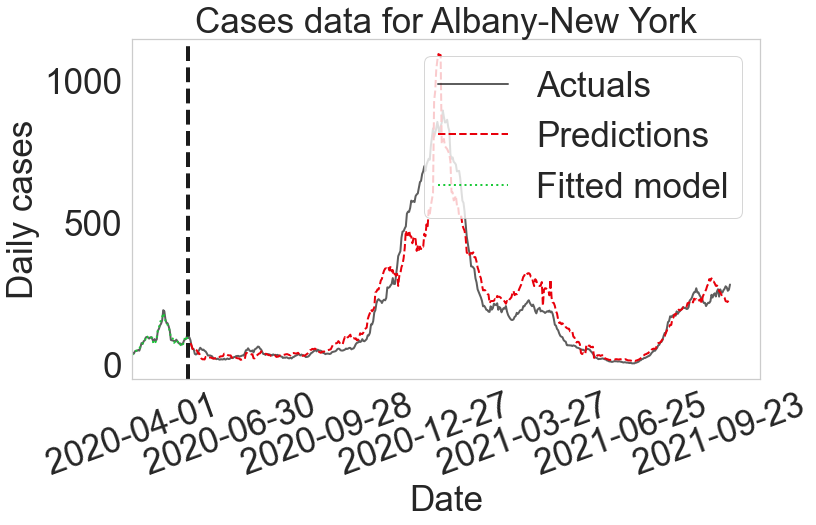

donors =  ['Atlantic-New Jersey', 'Barnstable-Massachusetts', 'Berkshire-Massachusetts', 'Bristol-Rhode Island', 'Cape May-New Jersey', 'Columbia-New York', 'Cumberland-Maine', 'Erie-New York', 'Franklin-Massachusetts', 'Fulton-New York', 'Genesee-New York', 'Gloucester-New Jersey', 'Greene-New York', 'Hampshire-Massachusetts', 'Hillsborough-New Hampshire', 'Hunterdon-New Jersey', 'Kent-Rhode Island', 'Litchfield-Connecticut', 'Madison-New York', 'Middlesex-Connecticut', 'New London-Connecticut', 'Niagara-New York', 'Onondaga-New York', 'Orleans-New York', 'Rockingham-New Hampshire', 'Schenectady-New York', 'Sussex-New Jersey', 'Tolland-Connecticut', 'Warren-New York', 'Washington-New York'] singvals: 9


In [104]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Albany-New York']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  wa

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

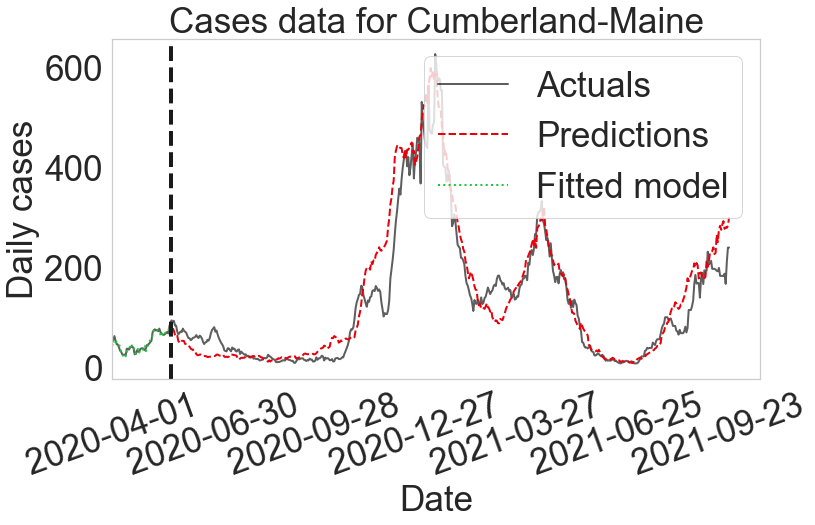

donors =  ['Androscoggin-Maine', 'Berkshire-Massachusetts', 'Bristol-Rhode Island', 'Chenango-New York', 'Chittenden-Vermont', 'Franklin-Massachusetts', 'Franklin-Vermont', 'Fulton-New York', 'Genesee-New York', 'Greene-New York', 'Hampshire-Massachusetts', 'Madison-New York', 'Merrimack-New Hampshire', 'Monroe-New York', 'New London-Connecticut', 'Newport-Rhode Island', 'Niagara-New York', 'Oneida-New York', 'Onondaga-New York', 'Orleans-New York', 'Rensselaer-New York', 'Rockingham-New Hampshire', 'Schenectady-New York', 'St. Lawrence-New York', 'Steuben-New York', 'Strafford-New Hampshire', 'Tioga-New York', 'Warren-New York', 'Washington-New York', 'Washington-Rhode Island', 'Windham-Vermont', 'Wyoming-New York'] singvals: 9


In [103]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Cumberland-Maine']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

target: Albany-New York
number of donors before filtering: 145
2
number of donors after filtering: 127
target rank estimation:  2
Albany-New York donors: 145
Cases on 2020-05-24: 94


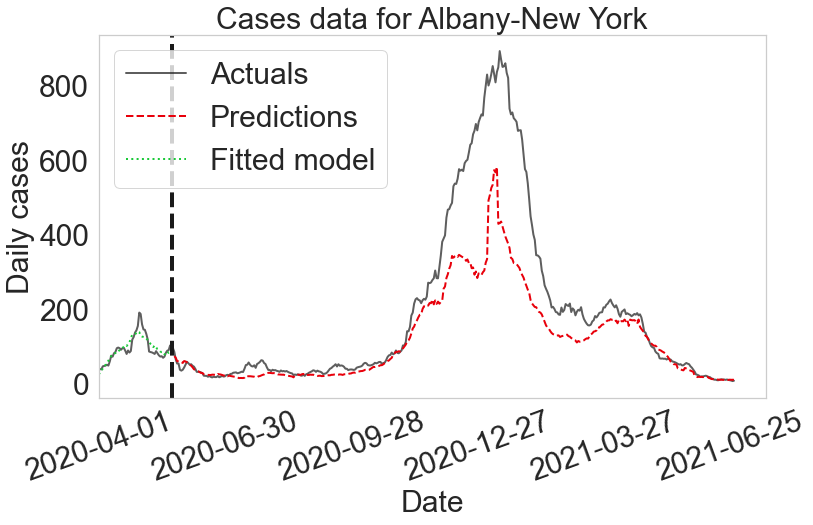

In [134]:

'''
import warnings
warnings.simplefilter('ignore')

FONTSIZE =  30
#lambdas = [1, 0.02]
test_days = 400
train_days = 53
singVals=4
tick_spacing = 90
aggregate1 = 0
aggregate2 = 0
weighted_avg1 = [0,0]
weighted_avg2 = [0,0]
low_thresh_date = '2020-05-24'
start_date = (dt.datetime.strptime(low_thresh_date,'%Y-%m-%d') - dt.timedelta(days = train_days)).strftime('%Y-%m-%d')
end_date = (dt.datetime.strptime(low_thresh_date,'%Y-%m-%d') + dt.timedelta(days = test_days)).strftime('%Y-%m-%d')
df = all_cases_data_pop.loc[start_date:]
df_pop = all_cases_data_pop_daily.loc[start_date:end_date]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
high_thresh = low_thresh + test_days + 1# df_pop.shape[0]

donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)

i = 0
#c = 50
for county_state in ['Albany-New York']:
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))
    
    if county_state in donors:
        donors.remove(county_state)  
    
    
    if len(donors) == 0:
        continue

    

    
    rscModel = syn_model(county_state, singVals, [df_pop], high_thresh, low_thresh, otherStates=donors)
    
    # to ensure there aren't too few donors
    new_donors = rscModel.donors
    if len(new_donors) < 3:
        continue
        
    print('target:', county_state)
    #rscModel.fit_model(filter_donor = False)
    print('number of donors before filtering:', len(rscModel.donors))
    
    try:
        rscModel.fit_model(filter_donor = True, singVals_estimate = True)
        print('number of donors after filtering:', len(rscModel.donors))
        print('target rank estimation: ', rscModel.kSingularValues)
    except:
        rscModel.fit_model(filter_donor = True)
        print('target model rank estimation failed, rank 2 ued by default')

    
    print(county_state+" donors: "+str(len(new_donors))
                     + "\nCases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[county_state].iloc[low_thresh])))
    
    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    
    #plot_counterfactual_vs_prediction(donors, [county_state])

    

    predictions = rscModel.predictions 
    model_fit = rscModel.model_fit
    
    aggregate_fit_change = (df_pop[county_state][:low_thresh]-model_fit)
    aggregate_pred_change = (df_pop[county_state][low_thresh+1:high_thresh]-predictions )
    aggregate1 += aggregate_pred_change[-1]    
        
    county_pop = uscounties_population.loc[county_state].value
    weighted_avg1[0] += aggregate_pred_change[-1] * county_pop #* county_pop/1e6
    weighted_avg1[1] += county_pop
    plt.show()
    
 '''   
